# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle that contains information on 3 million used cars.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

#### 1. Identify the features that drive the cost of a used car.
#### 2. Correlation of the features with the cost of used car.
#### 3. Create a model to predict the price of the used car based for the application users to make.
#### 4. Business inferences out of the prediction and the model created.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

#### 1. Check the column types and index column.
#### 2. Consider dropping columns that do not have correlation with cost e.g. Id, VIN etc.
#### 3. Columns that have high correlation can skew the result hence consider dropping those columns.
#### 4. Consider dropping NaN values or filling them up with mean of that column.
#### 5. Convert date column into datetime and set it as index for the DataFrame.
#### 6. Consider making category column numeric with category mapping.
#### 7. Plot the data to check the stationary nature of it.

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

## Importing the required libraries

In [20]:
import numpy as np
import pandas as pd
import datetime

import statsmodels.api as sm
import joblib
import sys

sys.modules['sklearn.externals.joblib'] = joblib

from sklearn.cluster import KMeans
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse
from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn import preprocessing
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as SFS_PLOT
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
import seaborn as sns

In [21]:
df = pd.read_csv('data/vehicles.csv')

## Drop the columns that are visibly not affecting the Price 
### 1. VIN
### 2. Id

In [22]:
df = df.drop('id',axis=1).drop('VIN',axis=1).drop('region',axis=1)
df['year'] = pd.to_datetime(df['year'])
df['year'] = df['year'].fillna(df['year'].mean())
df =  df.set_index('year')


## Using Category encoder to encode the category columns into numerics. 
### At this point the interest is to make the columns numeric to determine which columns will be needed for model preparation, we will apply one hot encoding at a later time once we have determined the features of interest.

In [25]:
cleanup_nums = {'state':{
        'AK': 'O',
        'AL': 'S',
        'AR': 'S',
        'AZ': 'W',
        'CA': 'W',
        'CO': 'W',
        'CT': 'N',
        'DC': 'N',
        'DE': 'N',
        'FL': 'S',
        'GA': 'S',
        'HI': 'O',
        'IA': 'M',
        'ID': 'W',
        'IL': 'M',
        'IN': 'M',
        'KS': 'M',
        'KY': 'S',
        'LA': 'S',
        'MA': 'N',
        'MD': 'N',
        'ME': 'N',
        'MI': 'W',
        'MN': 'M',
        'MO': 'M',
        'MS': 'S',
        'MT': 'W',
        'NC': 'S',
        'ND': 'M',
        'NE': 'W',
        'NH': 'N',
        'NJ': 'N',
        'NM': 'W',
        'NV': 'W',
        'NY': 'N',
        'OH': 'M',
        'OK': 'S',
        'OR': 'W',
        'PA': 'N',
        'RI': 'N',
        'SC': 'S',
        'SD': 'M',
        'TN': 'S',
        'TX': 'S',
        'UT': 'W',
        'VA': 'S',
        'VT': 'N',
        'WA': 'W',
        'WI': 'M',
        'WV': 'S',
        'WY': 'W'
}}


df['state'] = df['state'].str.upper()

df = df.replace(cleanup_nums) 
df['price'] = df['price'].fillna(df['price'].mean())
df['odometer'] = df['odometer'].fillna(df['odometer'].mean())
df['size'] = df['size'].fillna('sub-compact')
df['manufacturer'] = df['manufacturer'].fillna('subaru')
df['model'] = df['model'].fillna('silverado')
df['condition'] = df['condition'].fillna('fair')
df['cylinders'] = df['cylinders'].fillna('5 cylinders')
df['fuel'] = df['fuel'].fillna('hybrid')
df['title_status'] = df['title_status'].fillna('salvage')
df['transmission'] = df['transmission'].fillna('other')
df['drive'] = df['drive'].fillna('rwd')
df['type'] = df['type'].fillna('van')
df['paint_color'] = df['paint_color'].fillna('green')

In [26]:
df1=df.copy()
df1["condition"] = df1["condition"].astype('category')
df1["condition"] = df1["condition"].cat.codes

df1["fuel"] = df1["fuel"].astype('category')
df1["fuel"] = df1["fuel"].cat.codes

df1["cylinders"] = df1["cylinders"].astype('category')
df1["cylinders"] = df1["cylinders"].cat.codes

df1["title_status"] = df1["title_status"].astype('category')
df1["title_status"] = df1["title_status"].cat.codes

df1["transmission"] = df1["transmission"].astype('category')
df1["transmission"] = df1["transmission"].cat.codes

df1["drive"] = df1["drive"].astype('category')
df1["drive"] = df1["drive"].cat.codes

df1["size"] = df1["size"].astype('category')
df1["size"] = df1["size"].cat.codes

df1["type"] = df1["type"].astype('category')
df1["type"] = df1["type"].cat.codes

df1["paint_color"] = df1["paint_color"].astype('category')
df1["paint_color"] = df1["paint_color"].cat.codes

df1["model"] = df1["model"].astype('category')
df1["model"] = df1["model"].cat.codes

df1["manufacturer"] = df1["manufacturer"].astype('category')
df1["manufacturer"] = df1["manufacturer"].cat.codes

df1["state"] = df1["state"].astype('category')
df1["state"] = df1["state"].cat.codes

## Running the Variance Inflation Factor and Permutation importance will point us to the features that will have significant impact on the price of used car.

In [27]:
X = df1.drop('price',axis=1).drop('cylinders',axis=1).drop('size',axis=1)
#.drop('fuel',axis=1)
y = df1['price']
X.corr()

,manufacturer,model,condition,fuel,odometer,title_status,transmission,drive,type,paint_color,state
manufacturer,1.000000,-0.085490,-0.014958,-0.046002,0.010008,0.019659,0.012331,-0.055081,0.037736,0.014174,0.040623
model,-0.085490,1.000000,0.007161,0.071479,-0.005325,-0.005769,0.009526,-0.094501,-0.095741,0.012499,-0.003582
condition,-0.014958,0.007161,1.000000,0.129129,-0.033734,-0.084783,0.329091,0.093955,0.008304,0.015919,-0.040170
fuel,-0.046002,0.071479,0.129129,1.000000,-0.067373,0.001494,0.256775,0.106538,-0.114972,-0.037920,-0.040428
odometer,0.010008,-0.005325,-0.033734,-0.067373,1.000000,0.002326,-0.098538,-0.002446,0.036371,-0.000274,-0.000576
title_status,0.019659,-0.005769,-0.084783,0.001494,0.002326,1.000000,-0.041746,0.008120,-0.003205,-0.029301,0.023011
transmission,0.012331,0.009526,0.329091,0.256775,-0.098538,-0.041746,1.000000,0.154030,-0.056257,0.007718,-0.036513
drive,-0.055081,-0.094501,0.093955,0.106538,-0.002446,0.008120,0.154030,1.000000,0.195291,-0.005332,-0.005189
type,0.037736,-0.095741,0.008304,-0.114972,0.036371,-0.003205,-0.056257,0.195291,1.000000,0.007997,0.007298
paint_color,0.014174,0.012499,0.015919,-0.037920,-0.000274,-0.029301,0.007718,-0.005332,0.007997,1.000000,0.023955


In [28]:
X = df1.drop('price',axis=1).drop('size',axis=1).drop('cylinders',axis=1)
#.drop('fuel',axis=1)
y = df1['price']
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 42)
pd.Series([variance_inflation_factor(X_train.values, i) 
               for i in range(X_train.shape[1])], 
              index=X_train.columns).sort_values(ascending=False)
#df1.cylinders.value_counts()
#df1.size.value_counts()
#df1.fuel.value_counts()

fuel            6.454568
model           4.620788
type            3.797037
state           3.270099
manufacturer    3.265084
condition       3.053389
drive           2.919569
paint_color     2.908231
transmission    1.498479
odometer        1.225781
title_status    1.057208
dtype: float64

In [29]:
reg = LinearRegression()
new_sfs = SFS(reg,
             k_features=len(X_train.columns),
             forward=True,
             scoring="neg_root_mean_squared_error",
             cv=0)
sfs_model = new_sfs.fit(X_train,y_train)
sfs_model.get_metric_dict()
sfs_model.k_feature_names_

('manufacturer',
 'model',
 'condition',
 'fuel',
 'odometer',
 'title_status',
 'transmission',
 'drive',
 'type',
 'paint_color',
 'state')

## Plotting the SFS we see after 6 features the gain is not significant. We will go with 8 features to build the model

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Number of Features', ylabel='Performance'>)

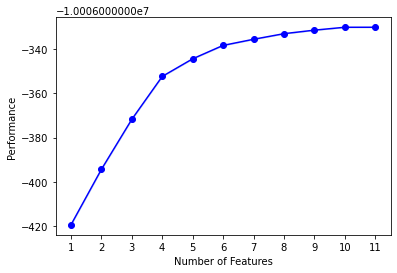

In [30]:
SFS_PLOT(sfs_model.get_metric_dict())

## Permutation importance gives us indications to the features that impact the price of the use car.

In [32]:
Xpi = df1.drop('price',axis=1).drop('cylinders',axis=1).drop('size',axis=1)
#.drop('fuel',axis=1)
ypi = df1['price']
Xpi_train, Xpi_test, ypi_train,ypi_test = train_test_split(Xpi,ypi,test_size = 0.3,random_state = 42)

reg = LinearRegression()
new_sfs = SFS(reg,
             k_features=9,
             forward=True,
             scoring="neg_root_mean_squared_error",
             cv=0)
sfs_model = new_sfs.fit(Xpi_train,ypi_train)
new_sfs.k_feature_names_
reg_model = reg.fit(Xpi_train,ypi_train)
ypi_pred = reg_model.predict(Xpi_test)
print(mean_absolute_error(ypi_pred,ypi_test))
r = permutation_importance(reg_model,Xpi_train,ypi_train,n_repeats=9,random_state=42)
#df_selected
r.importances_mean
pi = pd.DataFrame({"Features":Xpi_train.columns,"importance":r.importances_mean}).sort_values(by="importance",ascending=False)
print(pi)
df_selected = df1[['manufacturer',
 'fuel',
 'odometer',
 'title_status',
 'transmission',
 'drive',
 'type',
 'state',
 'price']]

157614.07460716774
        Features    importance
4       odometer  6.924138e-04
6   transmission  9.387056e-06
0   manufacturer  8.124463e-06
9    paint_color  5.210102e-06
8           type  5.062122e-06
5   title_status  2.733569e-06
10         state  7.501741e-07
7          drive  4.724789e-07
3           fuel  1.447702e-07
1          model  3.358880e-08
2      condition -5.231073e-08


## We apply one hot encoding at this point since we have all the features of interest identified

In [34]:
df1_selected = pd.get_dummies(df_selected, columns=['manufacturer','drive','fuel']).head()
df2_selected = pd.get_dummies(df1_selected, columns=['title_status','transmission']).head()
df3_selected = pd.get_dummies(df2_selected, columns=['type','state']).head()
print(df3_selected.columns)
df3_selected

Index(['odometer', 'price', 'manufacturer_0', 'manufacturer_1',
       'manufacturer_2', 'manufacturer_3', 'manufacturer_4', 'manufacturer_5',
       'manufacturer_6', 'manufacturer_7', 'manufacturer_8', 'manufacturer_9',
       'manufacturer_10', 'manufacturer_11', 'manufacturer_12',
       'manufacturer_13', 'manufacturer_14', 'manufacturer_15',
       'manufacturer_16', 'manufacturer_17', 'manufacturer_18',
       'manufacturer_19', 'manufacturer_20', 'manufacturer_21',
       'manufacturer_22', 'manufacturer_23', 'manufacturer_24',
       'manufacturer_25', 'manufacturer_26', 'manufacturer_27',
       'manufacturer_28', 'manufacturer_29', 'manufacturer_30',
       'manufacturer_31', 'manufacturer_32', 'manufacturer_33',
       'manufacturer_34', 'manufacturer_35', 'manufacturer_36',
       'manufacturer_37', 'manufacturer_38', 'manufacturer_39',
       'manufacturer_40', 'manufacturer_41', 'drive_0', 'drive_1', 'drive_2',
       'fuel_0', 'fuel_1', 'fuel_2', 'fuel_3', 'fuel_4', 'ti

,odometer,price,manufacturer_0,manufacturer_1,manufacturer_2,manufacturer_3,manufacturer_4,manufacturer_5,manufacturer_6,manufacturer_7,...,fuel_1,fuel_2,fuel_3,fuel_4,title_status_5,transmission_2,type_11,state_1,state_3,state_4
year,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:00.000002011,98043.331443,6000,0,0,0,0,0,0,0,0,...,0,0,1,0,1,1,1,0,0,1
1970-01-01 00:00:00.000002011,98043.331443,11900,0,0,0,0,0,0,0,0,...,0,0,1,0,1,1,1,0,1,0
1970-01-01 00:00:00.000002011,98043.331443,21000,0,0,0,0,0,0,0,0,...,0,0,1,0,1,1,1,0,1,0
1970-01-01 00:00:00.000002011,98043.331443,1500,0,0,0,0,0,0,0,0,...,0,0,1,0,1,1,1,1,0,0
1970-01-01 00:00:00.000002011,98043.331443,4900,0,0,0,0,0,0,0,0,...,0,0,1,0,1,1,1,0,1,0


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [35]:
X = df3_selected.drop('price',axis=1)
y=df3_selected['price']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3,random_state = 42)

Linear Regression MSE Train:-
[1.3786343542550462e-24, 2.2609603409782755e-23, 5.514537417020184e-25, 2.815171351388804e-22, 1.82227888945432e-21]
Linear Regression MSE Test:-
[12250000.0, 12250000.0, 12250000.0, 12250000.0, 12250000.0]
LeaveOneOut Cross Validation :-
[array([-2.975625e+08, -2.756250e+07, -1.440000e+08]), array([-2.975625e+08, -2.756250e+07, -1.440000e+08]), array([-2.975625e+08, -2.756250e+07, -1.440000e+08]), array([-2.975625e+08, -2.756250e+07, -1.440000e+08]), array([-2.975625e+08, -2.756250e+07, -1.440000e+08])]
KFold
[array([-2.975625e+08, -1.440000e+08, -2.756250e+07]), array([-2.975625e+08, -1.440000e+08, -2.756250e+07]), array([-2.975625e+08, -1.440000e+08, -2.756250e+07]), array([-2.975625e+08, -1.440000e+08, -2.756250e+07]), array([-2.975625e+08, -1.440000e+08, -2.756250e+07])]


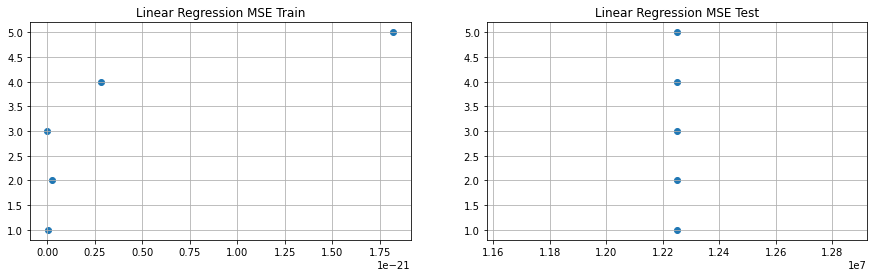

In [36]:
linear_mse_train=[]
linear_mse_test=[]
cvll=[]
cvlkf=[]
degree=[]
for i in range(1,6):
    degree.append(i)
    linear=Pipeline([('polyfeatures', PolynomialFeatures(degree = i,include_bias=False)),\
    ('Scaler', StandardScaler()),('LINEAR', LinearRegression())])
    
    linear.fit(X_train,y_train)
    lr = linear.predict(X_train)
    linear_mse_train.append(mean_squared_error(lr,y_train))

    linear.fit(X_test,y_test)
    lr = linear.predict(X_test)
    linear_mse_test.append(mean_squared_error(lr,y_test))
    
    l = LeaveOneOut()
    cvll.append(cross_val_score(linear, X_train, y_train, cv=l, scoring='neg_mean_squared_error'))

    kf = KFold(n_splits=3, random_state=21, shuffle=True)
    cvlkf.append(cross_val_score(linear, X_train, y_train, cv=kf, scoring='neg_mean_squared_error'))
    
fig, ax = plt.subplots(1, 2, figsize = (15, 4))
ax[0].scatter(linear_mse_train,degree)
ax[0].grid()
ax[0].set_title('Linear Regression MSE Train')
ax[1].scatter(linear_mse_test,degree)
ax[1].grid()
ax[1].set_title('Linear Regression MSE Test');

print("Linear Regression MSE Train:-")
print(linear_mse_train)
print("Linear Regression MSE Test:-")
print(linear_mse_test)
print("LeaveOneOut Cross Validation :-")
print(cvll)
print("KFold")
print(cvlkf)

K Neighboring Node Regression MSE Train:-
[69500000.0, 69500000.0, 69500000.0, 69500000.0, 69500000.0]
K Neighboring Node Regression MSE Test:-
[12250000.0, 12250000.0, 12250000.0, 12250000.0, 12250000.0]
LeaveOneOut Cross Validation :-
[array([-2.975625e+08, -2.756250e+07, -1.440000e+08]), array([-2.975625e+08, -2.756250e+07, -1.440000e+08]), array([-2.975625e+08, -2.756250e+07, -1.440000e+08]), array([-2.975625e+08, -2.756250e+07, -1.440000e+08]), array([-2.975625e+08, -2.756250e+07, -1.440000e+08])]
KFold
[array([-2.975625e+08, -1.440000e+08, -2.756250e+07]), array([-2.975625e+08, -1.440000e+08, -2.756250e+07]), array([-2.975625e+08, -1.440000e+08, -2.756250e+07]), array([-2.975625e+08, -1.440000e+08, -2.756250e+07]), array([-2.975625e+08, -1.440000e+08, -2.756250e+07])]


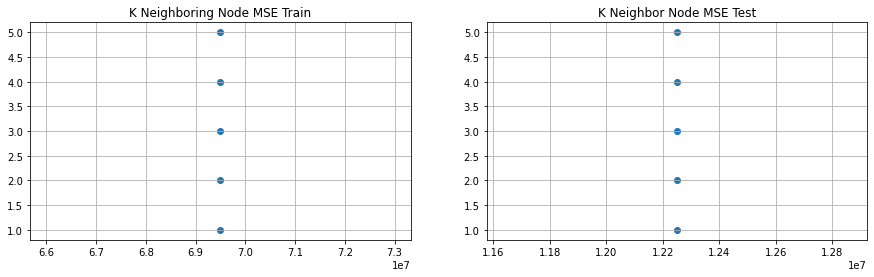

In [37]:
knn_mse_train=[]
knn_mse_test=[]
degree=[]
cvll=[]
cvlkf=[]
for i in range(1,6):
    degree.append(i)
    knn=Pipeline([('polyfeatures', PolynomialFeatures(degree = i,include_bias=False)),\
                    ('Scaler', StandardScaler()),('KNN', KNeighborsRegressor(n_neighbors=3))])
    knn.fit(X_train,y_train)
    knnr = knn.predict(X_train)
    knn_mse_train.append(mean_squared_error(knnr,y_train))

    knn=Pipeline([('polyfeatures', PolynomialFeatures(degree = i,include_bias=False)),\
                    ('Scaler', StandardScaler()),('KNN', KNeighborsRegressor(n_neighbors=2))])
    
    knn.fit(X_test,y_test)
    knnr = knn.predict(X_test)
    knn_mse_test.append(mean_squared_error(knnr,y_test))

    lknn = LeaveOneOut()
    cvll.append(cross_val_score(knn, X_train, y_train, cv=lknn, scoring='neg_mean_squared_error'))

    kfknn = KFold(n_splits=3, random_state=21, shuffle=True)
    cvlkf.append(cross_val_score(knn, X_train, y_train, cv=kfknn, scoring='neg_mean_squared_error'))

fig, ax = plt.subplots(1, 2, figsize = (15, 4))
ax[0].scatter(knn_mse_train,degree)
ax[0].grid()
ax[0].set_title('K Neighboring Node MSE Train')
ax[1].scatter(knn_mse_test,degree)
ax[1].grid()
ax[1].set_title('K Neighbor Node MSE Test');

print("K Neighboring Node Regression MSE Train:-")
print(knn_mse_train)
print("K Neighboring Node Regression MSE Test:-")
print(knn_mse_test)
print("LeaveOneOut Cross Validation :-")
print(cvll)
print("KFold")
print(cvlkf)

Elastic Net MSE Train:-
[4345774.894600508, 89006.19026765502, 3549.446304213549, 3569.4795440789, 0.7714068872585774]
Elastic Net MSE Test:-
[12250000.0, 12250000.0, 12250000.0, 12250000.0, 12250000.0]
LeaveOneOut Cross Validation :-
[array([-2.97560451e+08, -2.75652028e+07, -1.43995248e+08]), array([-2.97562296e+08, -2.75626729e+07, -1.43999696e+08]), array([-2.97563379e+08, -2.75613404e+07, -1.44002039e+08]), array([-2.975625e+08, -2.756250e+07, -1.440000e+08]), array([-2.975625e+08, -2.756250e+07, -1.440000e+08])]
KFold:-
[array([-2.97560451e+08, -1.43995248e+08, -2.75652028e+07]), array([-2.97562296e+08, -1.43999696e+08, -2.75626729e+07]), array([-2.97563379e+08, -1.44002039e+08, -2.75613404e+07]), array([-2.975625e+08, -1.440000e+08, -2.756250e+07]), array([-2.975625e+08, -1.440000e+08, -2.756250e+07])]


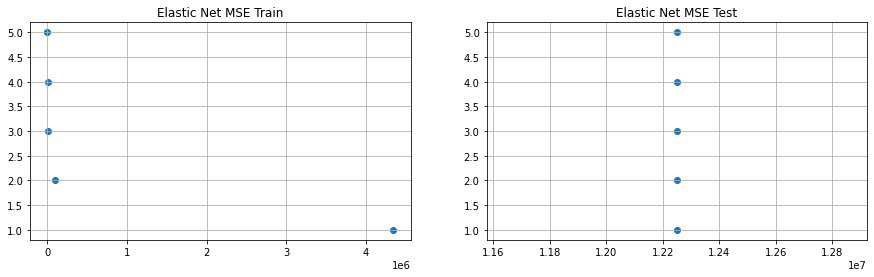

In [38]:
en_mse_train=[]
en_mse_test=[]
degree=[]
cvll=[]
cvlkf=[]
for i in range(1,6):
    degree.append(i)
    en=Pipeline([('polyfeatures', PolynomialFeatures(degree = i,include_bias=False)),\
                    ('Scaler', StandardScaler()),('EN', ElasticNet())])
    en.fit(X_train,y_train)
    enr = en.predict(X_train)
    en_mse_train.append(mean_squared_error(enr,y_train))

    en.fit(X_test,y_test)
    enr = en.predict(X_test)
    en_mse_test.append(mean_squared_error(enr,y_test))

    l = LeaveOneOut()
    cvll.append(cross_val_score(en, X_train, y_train, cv=l, scoring='neg_mean_squared_error'))

    kf = KFold(n_splits=3, random_state=21, shuffle=True)
    cvlkf.append(cross_val_score(en, X_train, y_train, cv=kf, scoring='neg_mean_squared_error'))
    
fig, ax = plt.subplots(1, 2, figsize = (15, 4))
ax[0].scatter(en_mse_train,degree)
ax[0].grid()
ax[0].set_title('Elastic Net MSE Train')
ax[1].scatter(en_mse_test,degree)
ax[1].grid()
ax[1].set_title('Elastic Net MSE Test');



print("Elastic Net MSE Train:-")
print(en_mse_train)
print("Elastic Net MSE Test:-")
print(en_mse_test)
print("LeaveOneOut Cross Validation :-")
print(cvll)
print("KFold:-")
print(cvlkf)

Decision Tree Regressor MSE Train:-
[0.0, 0.0, 0.0, 0.0, 0.0]
Decision Tree Regressor MSE Test:-
[12250000.0, 12250000.0, 12250000.0, 12250000.0, 12250000.0]
LeaveOneOut Cross Validation :-
[array([-2.250e+08, -2.250e+08, -2.025e+07]), array([-2.250e+08, -2.250e+08, -2.025e+07]), array([-2.2500e+08, -2.0250e+07, -3.8025e+08]), array([-2.250e+08, -2.025e+07, -2.025e+07]), array([-3.8025e+08, -2.2500e+08, -2.0250e+07])]
KFold :-
[array([-3.8025e+08, -3.8025e+08, -2.0250e+07]), array([-2.250e+08, -2.025e+07, -2.250e+08]), array([-2.2500e+08, -3.8025e+08, -2.0250e+07]), array([-2.250e+08, -2.025e+07, -2.250e+08]), array([-2.250e+08, -2.025e+07, -2.250e+08])]


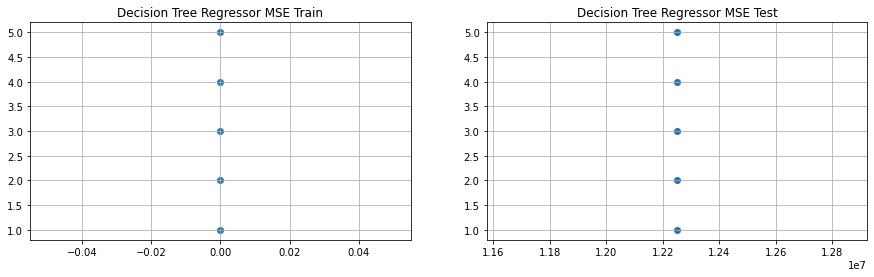

In [16]:
cart_mse_train=[]
cart_mse_test=[]
degree=[]
cvll=[]
cvlkf=[]
for i in range(1,6):
    degree.append(i)
    cart=Pipeline([('polyfeatures', PolynomialFeatures(degree = i,include_bias=False)),\
                    ('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])
    cart.fit(X_train,y_train)
    cartr = cart.predict(X_train)
    cart_mse_train.append(mean_squared_error(cartr,y_train))

    cart.fit(X_test,y_test)
    cartr = cart.predict(X_test)
    cart_mse_test.append(mean_squared_error(cartr,y_test))

    l = LeaveOneOut()
    cvll.append(cross_val_score(cart, X_train, y_train, cv=l, scoring='neg_mean_squared_error'))

    kf = KFold(n_splits=3, random_state=21, shuffle=True)
    cvlkf.append(cross_val_score(cart, X_train, y_train, cv=kf, scoring='neg_mean_squared_error'))

fig, ax = plt.subplots(1, 2, figsize = (15, 4))
ax[0].scatter(cart_mse_train,degree)
ax[0].grid()
ax[0].set_title('Decision Tree Regressor MSE Train')
ax[1].scatter(cart_mse_test,degree)
ax[1].grid()
ax[1].set_title('Decision Tree Regressor MSE Test');

print("Decision Tree Regressor MSE Train:-")
print(cart_mse_train)
print("Decision Tree Regressor MSE Test:-")
print(cart_mse_test)
print("LeaveOneOut Cross Validation :-")
print(cvll)
print("KFold :-")
print(cvlkf)

Gradient Boosting Regressor MSE Train:-
[0.04903279980530064, 0.04903279980530064, 0.04903279980530064]
Gradient Boosting Regressor MSE Test:-
[12250000.0, 12250000.0, 12250000.0]
LeaveOneOut Cross Validation :-
[array([-2.95769162e+08, -4.21558227e+07, -1.73240026e+08]), array([-2.83568308e+08, -6.80829612e+07, -2.05215807e+08]), array([-2.96995637e+08, -4.69800785e+07, -1.25732719e+08])]
KFold:-
[array([-2.99453893e+08, -1.18578960e+08, -2.59878105e+07]), array([-2.88057123e+08, -1.52094529e+08, -1.39238022e+07]), array([-2.88319748e+08, -1.76939345e+08, -2.00273677e+07])]


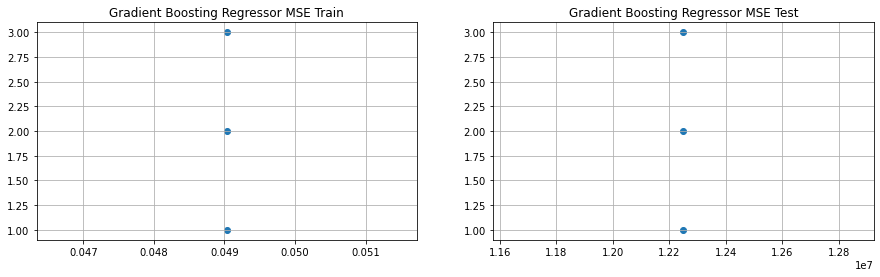

In [39]:
gbm_mse_train=[]
gbm_mse_test=[]
degree=[]
cvll=[]
cvlkf=[]
for i in range(1,4):
    degree.append(i)
    gbm=Pipeline([('polyfeatures', PolynomialFeatures(degree = i,include_bias=False)),\
                    ('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])
    gbm.fit(X_train,y_train)
    gbmr = gbm.predict(X_train)
    gbm_mse_train.append(mean_squared_error(gbmr,y_train))

    gbm.fit(X_test,y_test)
    gbmr = gbm.predict(X_test)
    gbm_mse_test.append(mean_squared_error(gbmr,y_test))

    l = LeaveOneOut()
    cvll.append(cross_val_score(gbm, X_train, y_train, cv=l, scoring='neg_mean_squared_error'))

    kf = KFold(n_splits=3, random_state=21, shuffle=True)
    cvlkf.append(cross_val_score(gbm, X_train, y_train, cv=kf, scoring='neg_mean_squared_error'))

fig, ax = plt.subplots(1, 2, figsize = (15, 4))
ax[0].scatter(gbm_mse_train,degree)
ax[0].grid()
ax[0].set_title('Gradient Boosting Regressor MSE Train')
ax[1].scatter(gbm_mse_test,degree)
ax[1].grid()
ax[1].set_title('Gradient Boosting Regressor MSE Test');

print("Gradient Boosting Regressor MSE Train:-")
print(gbm_mse_train)
print("Gradient Boosting Regressor MSE Test:-")
print(gbm_mse_test)
print("LeaveOneOut Cross Validation :-")
print(cvll)
print("KFold:-")
print(cvlkf)

Lasso MSE Train:-
[1.9259259259254329, 1.3333409627561907, 1.333332379604242, 1.333332379604242, 1.333332379604242]
Lasso MSE Test:-
[12250000.0, 12250000.0, 12250000.0, 12250000.0, 12250000.0]
LeaveOneOut Cross Validation :-
[array([-2.25030001e+08, -2.24970001e+08, -2.02590010e+07]), array([-2.25030001e+08, -2.24970001e+08, -2.02590010e+07]), array([-2.25030001e+08, -2.24970001e+08, -2.02590010e+07]), array([-2.25030001e+08, -2.24970001e+08, -2.02590010e+07]), array([-2.25030001e+08, -2.24970001e+08, -2.02590010e+07]), array([-2.25030001e+08, -2.24970001e+08, -2.02590010e+07]), array([-2.25030001e+08, -2.24970001e+08, -2.02590010e+07]), array([-2.25030001e+08, -2.24970001e+08, -2.02590010e+07]), array([-2.25030001e+08, -2.24970001e+08, -2.02590010e+07]), array([-2.25030001e+08, -2.24970001e+08, -2.02590010e+07])]
KFold:-
[array([-2.25030001e+08, -2.02590010e+07, -2.24970001e+08]), array([-2.25030001e+08, -2.02590010e+07, -2.24970001e+08]), array([-2.25030001e+08, -2.02590010e+07, -2.

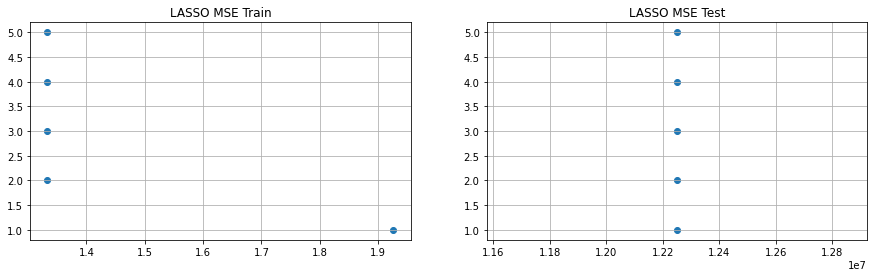

In [40]:
lasso_mse_train=[]
lasso_mse_test=[]
degree=[]
cvll=[]
cvlkf=[]
for i in range(1,6):
    degree.append(i)
    lasso=Pipeline([('polyfeatures', PolynomialFeatures(degree = i,include_bias=False)),\
                    ('Scaler', StandardScaler()),('LASSO', Lasso())])
    lasso.fit(X_train,y_train)
    lassor = lasso.predict(X_train)
    lasso_mse_train.append(mean_squared_error(lassor,y_train))
    l = LeaveOneOut()
    cvll.append(cross_val_score(lasso, X_train, y_train, cv=l, scoring='neg_mean_squared_error'))

    kf = KFold(n_splits=3, random_state=21, shuffle=True)
    cvlkf.append(cross_val_score(lasso, X_train, y_train, cv=kf, scoring='neg_mean_squared_error'))

    lasso.fit(X_test,y_test)
    lassor = lasso.predict(X_test)
    lasso_mse_test.append(mean_squared_error(lassor,y_test))
    
    l = LeaveOneOut()
    cvll.append(cross_val_score(lasso, X_train, y_train, cv=l, scoring='neg_mean_squared_error'))

    kf = KFold(n_splits=3, random_state=21, shuffle=True)
    cvlkf.append(cross_val_score(lasso, X_train, y_train, cv=kf, scoring='neg_mean_squared_error'))


fig, ax = plt.subplots(1, 2, figsize = (15, 4))
ax[0].scatter(lasso_mse_train,degree)
ax[0].grid()
ax[0].set_title('LASSO MSE Train')
ax[1].scatter(lasso_mse_test,degree)
ax[1].grid()
ax[1].set_title('LASSO MSE Test');

print("Lasso MSE Train:-")
print(lasso_mse_train)
print("Lasso MSE Test:-")
print(lasso_mse_test)
print("LeaveOneOut Cross Validation :-")
print(cvll)
print("KFold:-")
print(cvlkf)

Random Forest Regression MSE Train:-
[70710000.0, 70710000.0, 70710000.0, 70710000.0, 70710000.0]
Random Forest Regression MSE Test:-
[12254900.0, 12254900.0, 12269600.0, 12251225.0, 12349225.0]
LeaveOneOut Cross Validation :-
[array([-2.975625e+08, -2.361960e+07, -1.334025e+08]), array([-3.069504e+08, -2.361960e+07, -1.265625e+08]), array([-2.9138490e+08, -2.1762225e+07, -1.4400000e+08]), array([-3.05375625e+08, -3.87506250e+07, -1.66410000e+08]), array([-2.99117025e+08, -4.63761000e+07, -1.19902500e+08]), array([-2.92923225e+08, -2.55530250e+07, -1.44000000e+08]), array([-3.101121e+08, -3.180960e+07, -1.368900e+08]), array([-2.99117025e+08, -2.96480250e+07, -1.58760000e+08]), array([-2.852721e+08, -1.089000e+07, -1.299600e+08]), array([-3.006756e+08, -4.121640e+07, -1.299600e+08])]
KFold:-
[array([-2.83754025e+08, -1.33402500e+08, -1.99809000e+07]), array([-3.006756e+08, -1.368900e+08, -2.361960e+07]), array([-3.11699025e+08, -1.33402500e+08, -1.82756250e+07]), array([-2.8527210e+08,

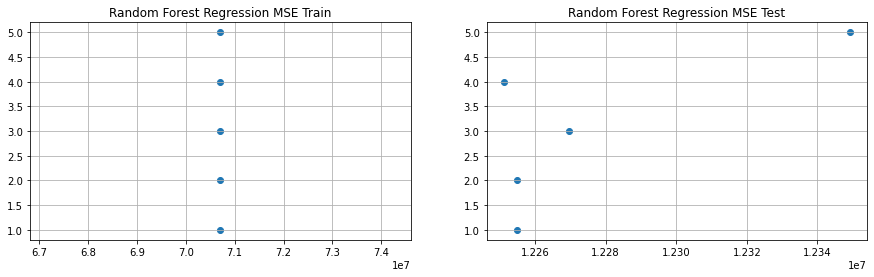

In [41]:
RandomForestRegressor(n_estimators = 100, random_state = 0)
rf_mse_train=[]
rf_mse_test=[]
degree=[]
cvll=[]
cvlkf=[]
for i in range(1,6):
    degree.append(i)
    rf=Pipeline([('polyfeatures', PolynomialFeatures(degree = i,include_bias=False)),\
                    ('Scaler', StandardScaler()),('Random Forest Regressor', RandomForestRegressor())])
    rf.fit(X_train,y_train)
    rfr = lasso.predict(X_train)
    rf_mse_train.append(mean_squared_error(rfr,y_train))
    l = LeaveOneOut()
    cvll.append(cross_val_score(rf, X_train, y_train, cv=l, scoring='neg_mean_squared_error'))

    kf = KFold(n_splits=3, random_state=21, shuffle=True)
    cvlkf.append(cross_val_score(rf, X_train, y_train, cv=kf, scoring='neg_mean_squared_error'))

    rf.fit(X_test,y_test)
    rfr = rf.predict(X_test)
    rf_mse_test.append(mean_squared_error(rfr,y_test))
    
    l = LeaveOneOut()
    cvll.append(cross_val_score(rf, X_train, y_train, cv=l, scoring='neg_mean_squared_error'))

    kf = KFold(n_splits=3, random_state=21, shuffle=True)
    cvlkf.append(cross_val_score(rf, X_train, y_train, cv=kf, scoring='neg_mean_squared_error'))


fig, ax = plt.subplots(1, 2, figsize = (15, 4))
ax[0].scatter(rf_mse_train,degree)
ax[0].grid()
ax[0].set_title('Random Forest Regression MSE Train')
ax[1].scatter(rf_mse_test,degree)
ax[1].grid()
ax[1].set_title('Random Forest Regression MSE Test');

print("Random Forest Regression MSE Train:-")
print(rf_mse_train)
print("Random Forest Regression MSE Test:-")
print(rf_mse_test)
print("LeaveOneOut Cross Validation :-")
print(cvll)
print("KFold:-")
print(cvlkf)

## Linear Regression comes on the top of all other regression model for this scenario

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

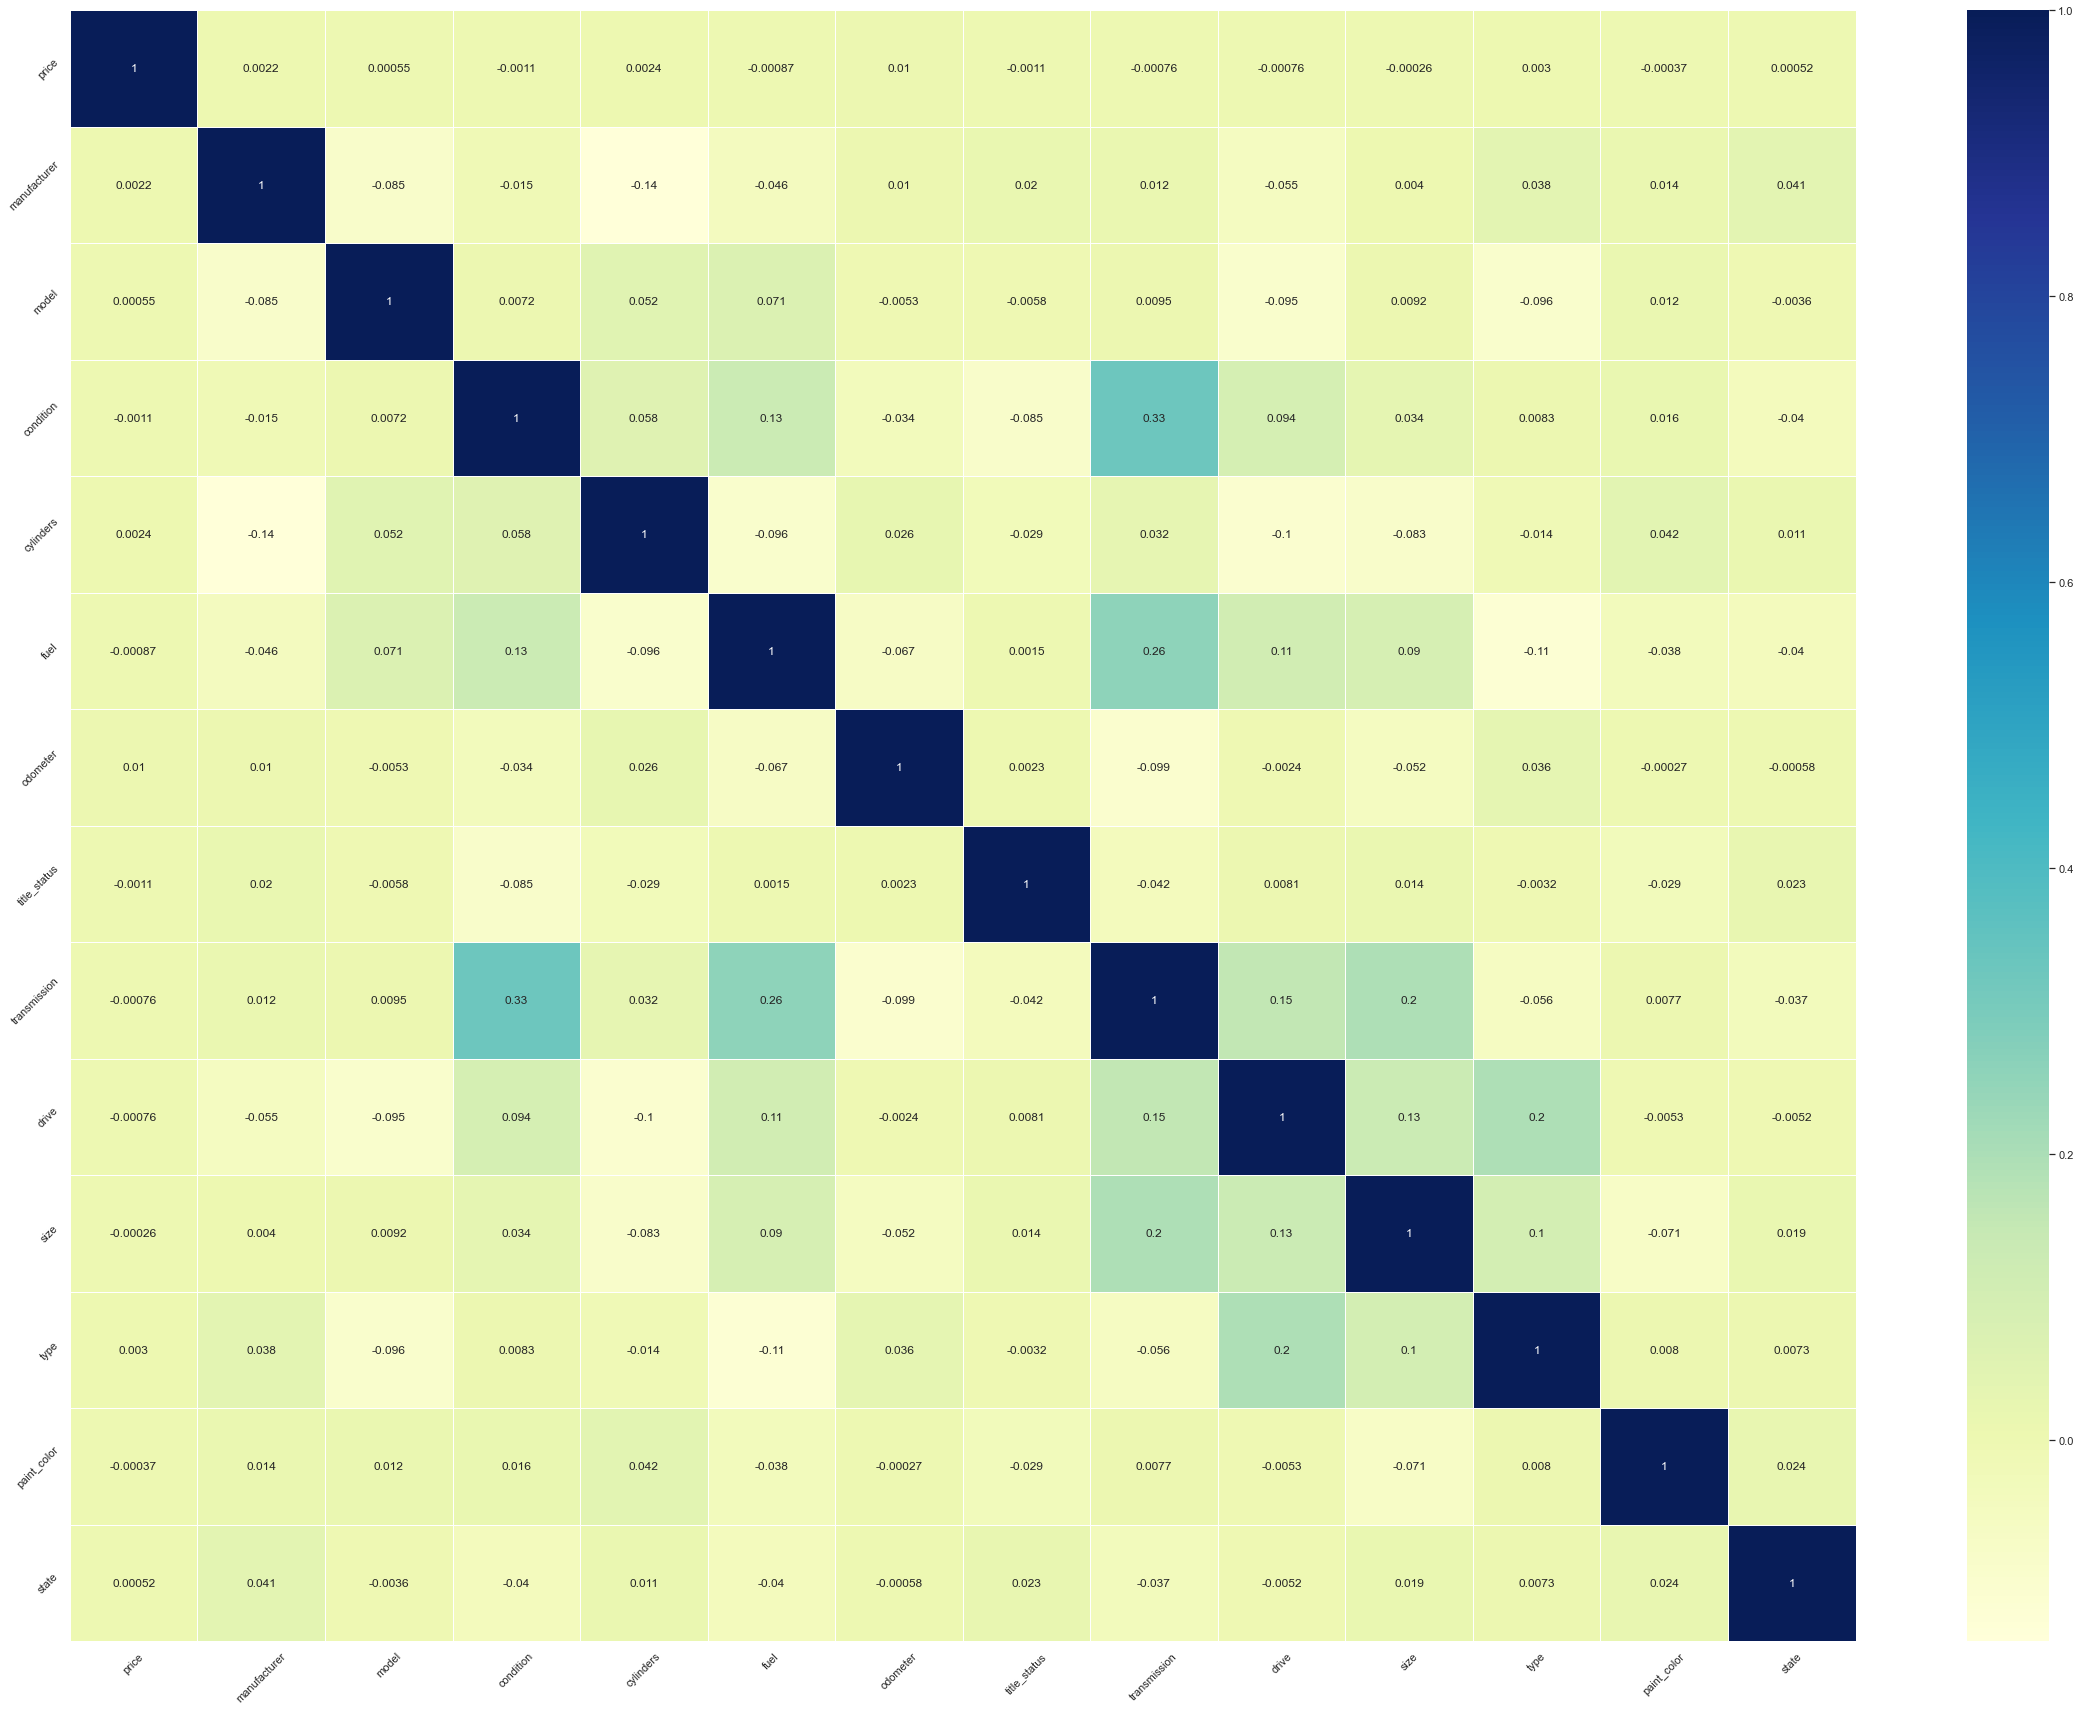

In [43]:
df2=df1.reset_index().drop('year',axis=1).corr()
sns.heatmap(data=df2, linewidths=.5,cmap="YlGnBu",annot=True)
sns.set(rc={'figure.figsize':(40,30)})
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

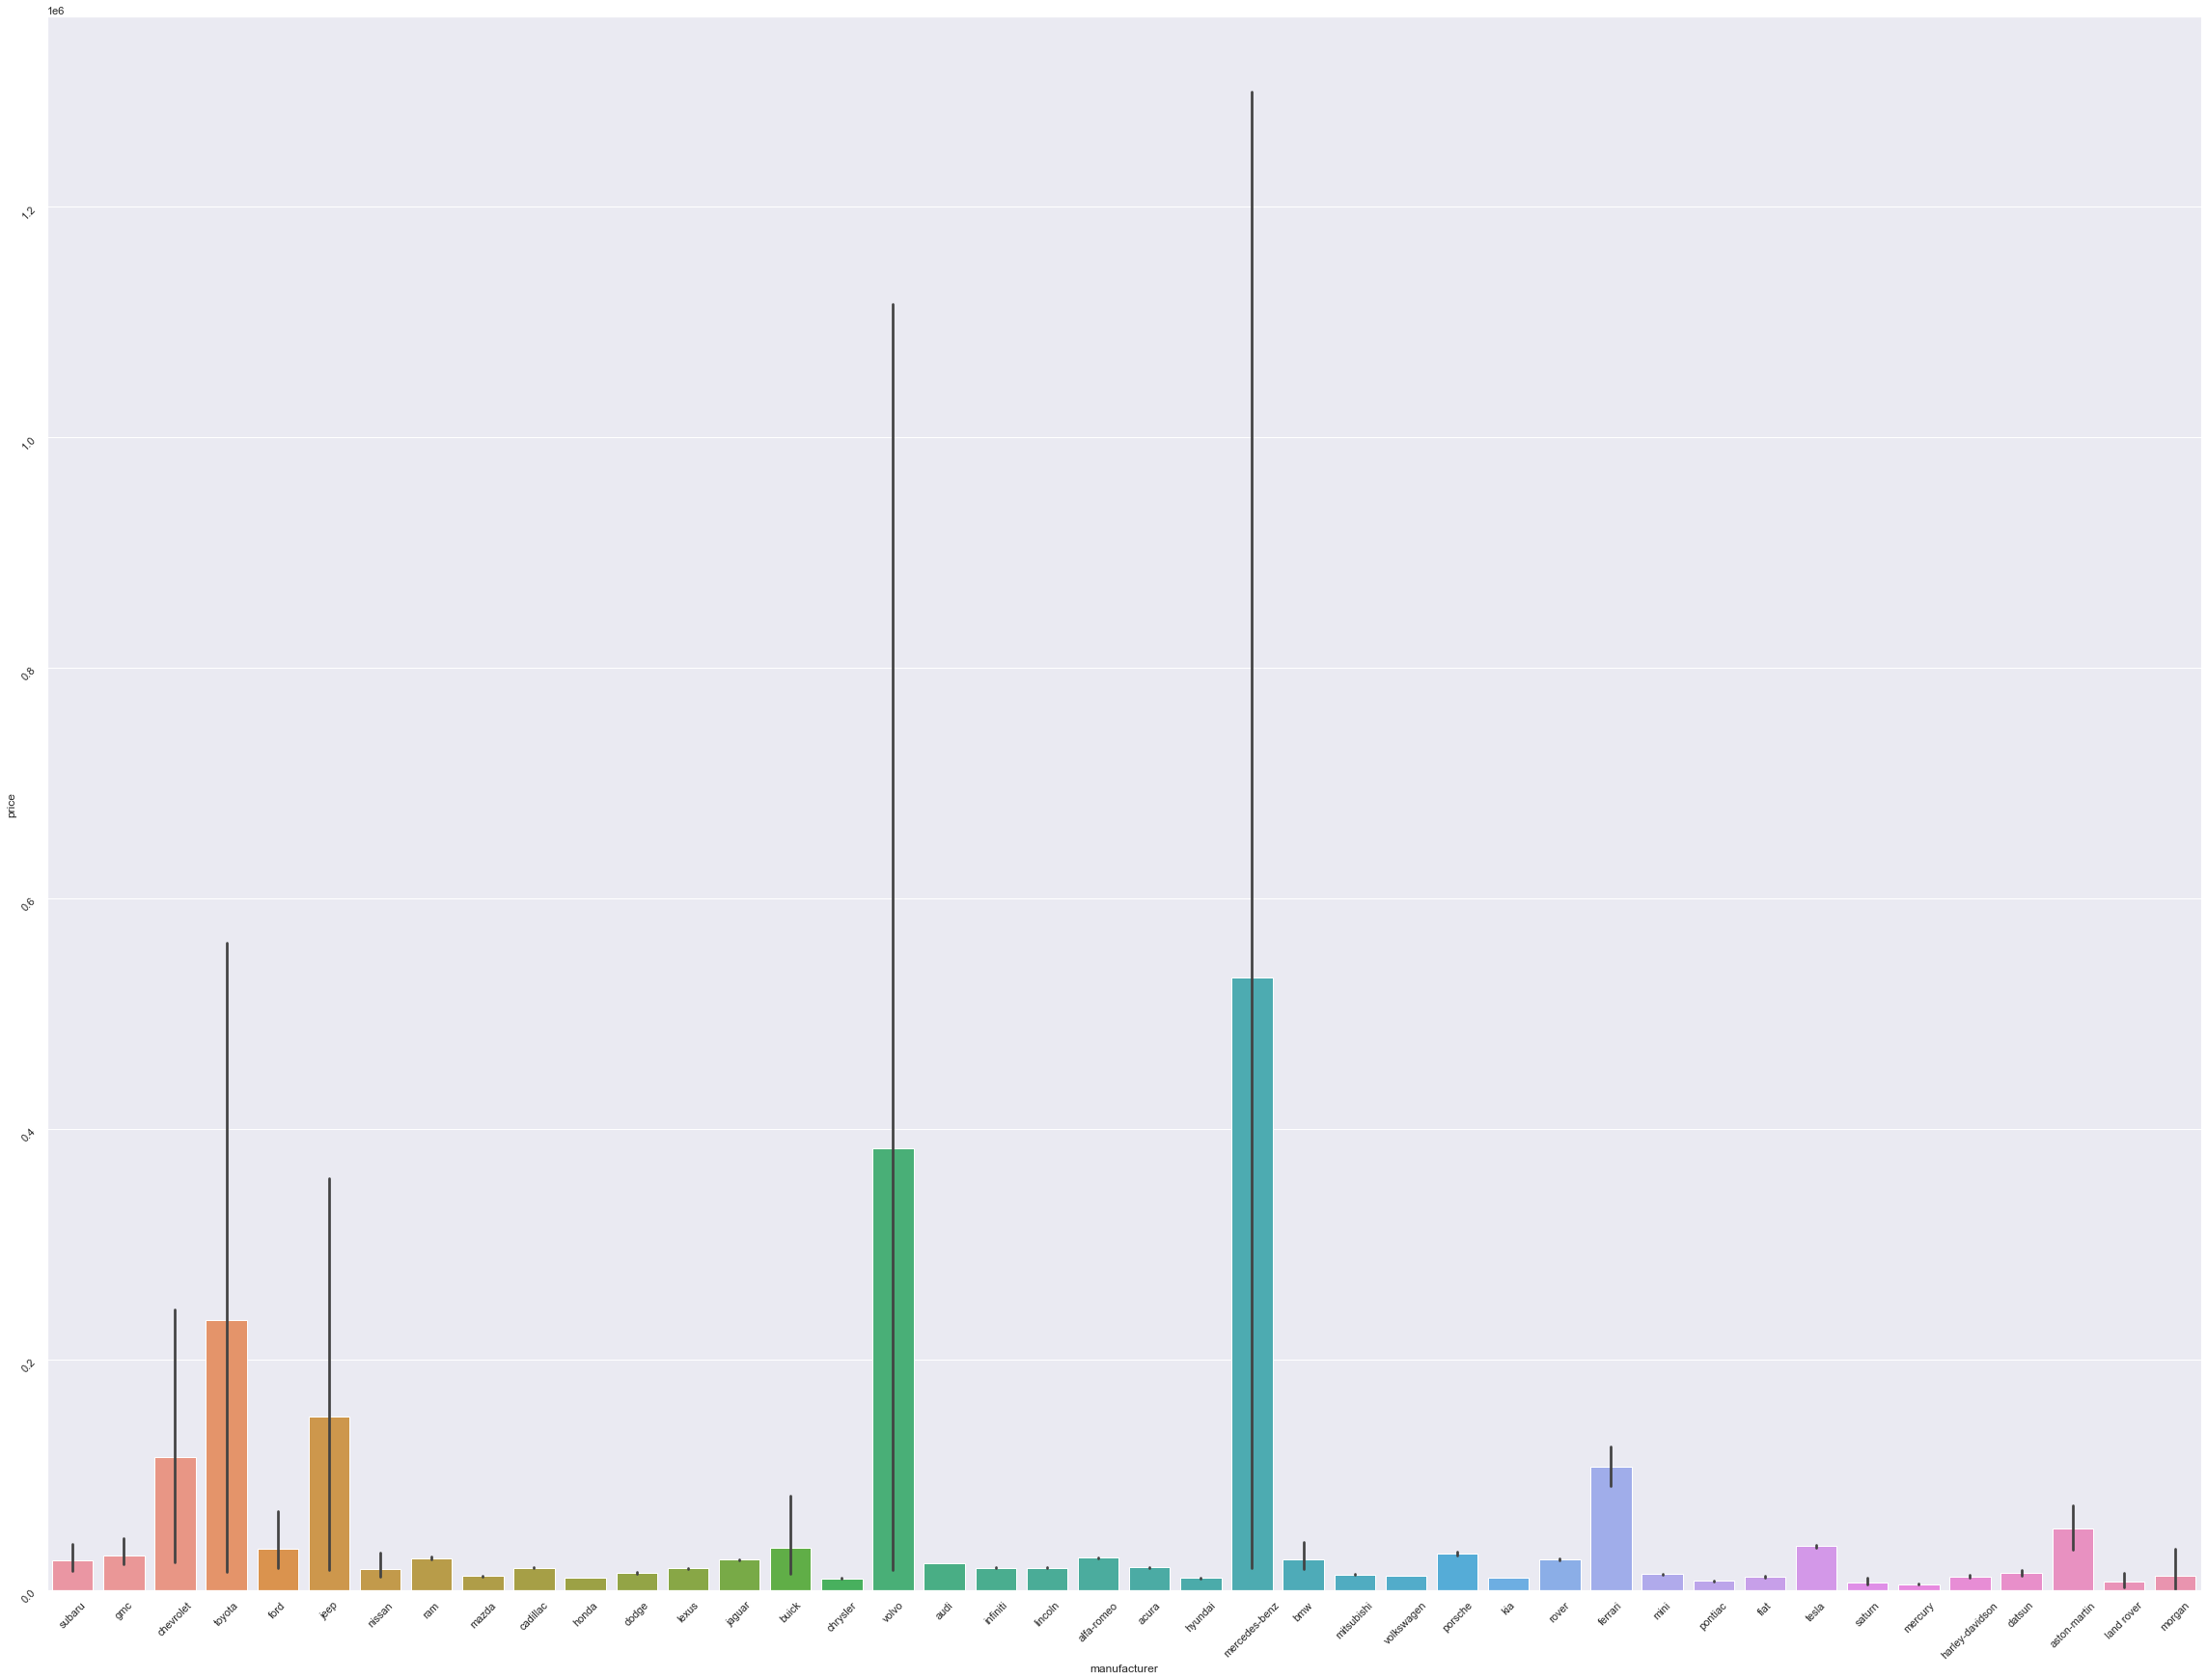

In [44]:
#'manufacturer','fuel','odometer','title_status','transmission','drive','type','state','price'
sns.barplot(data=df,x='manufacturer',y='price')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

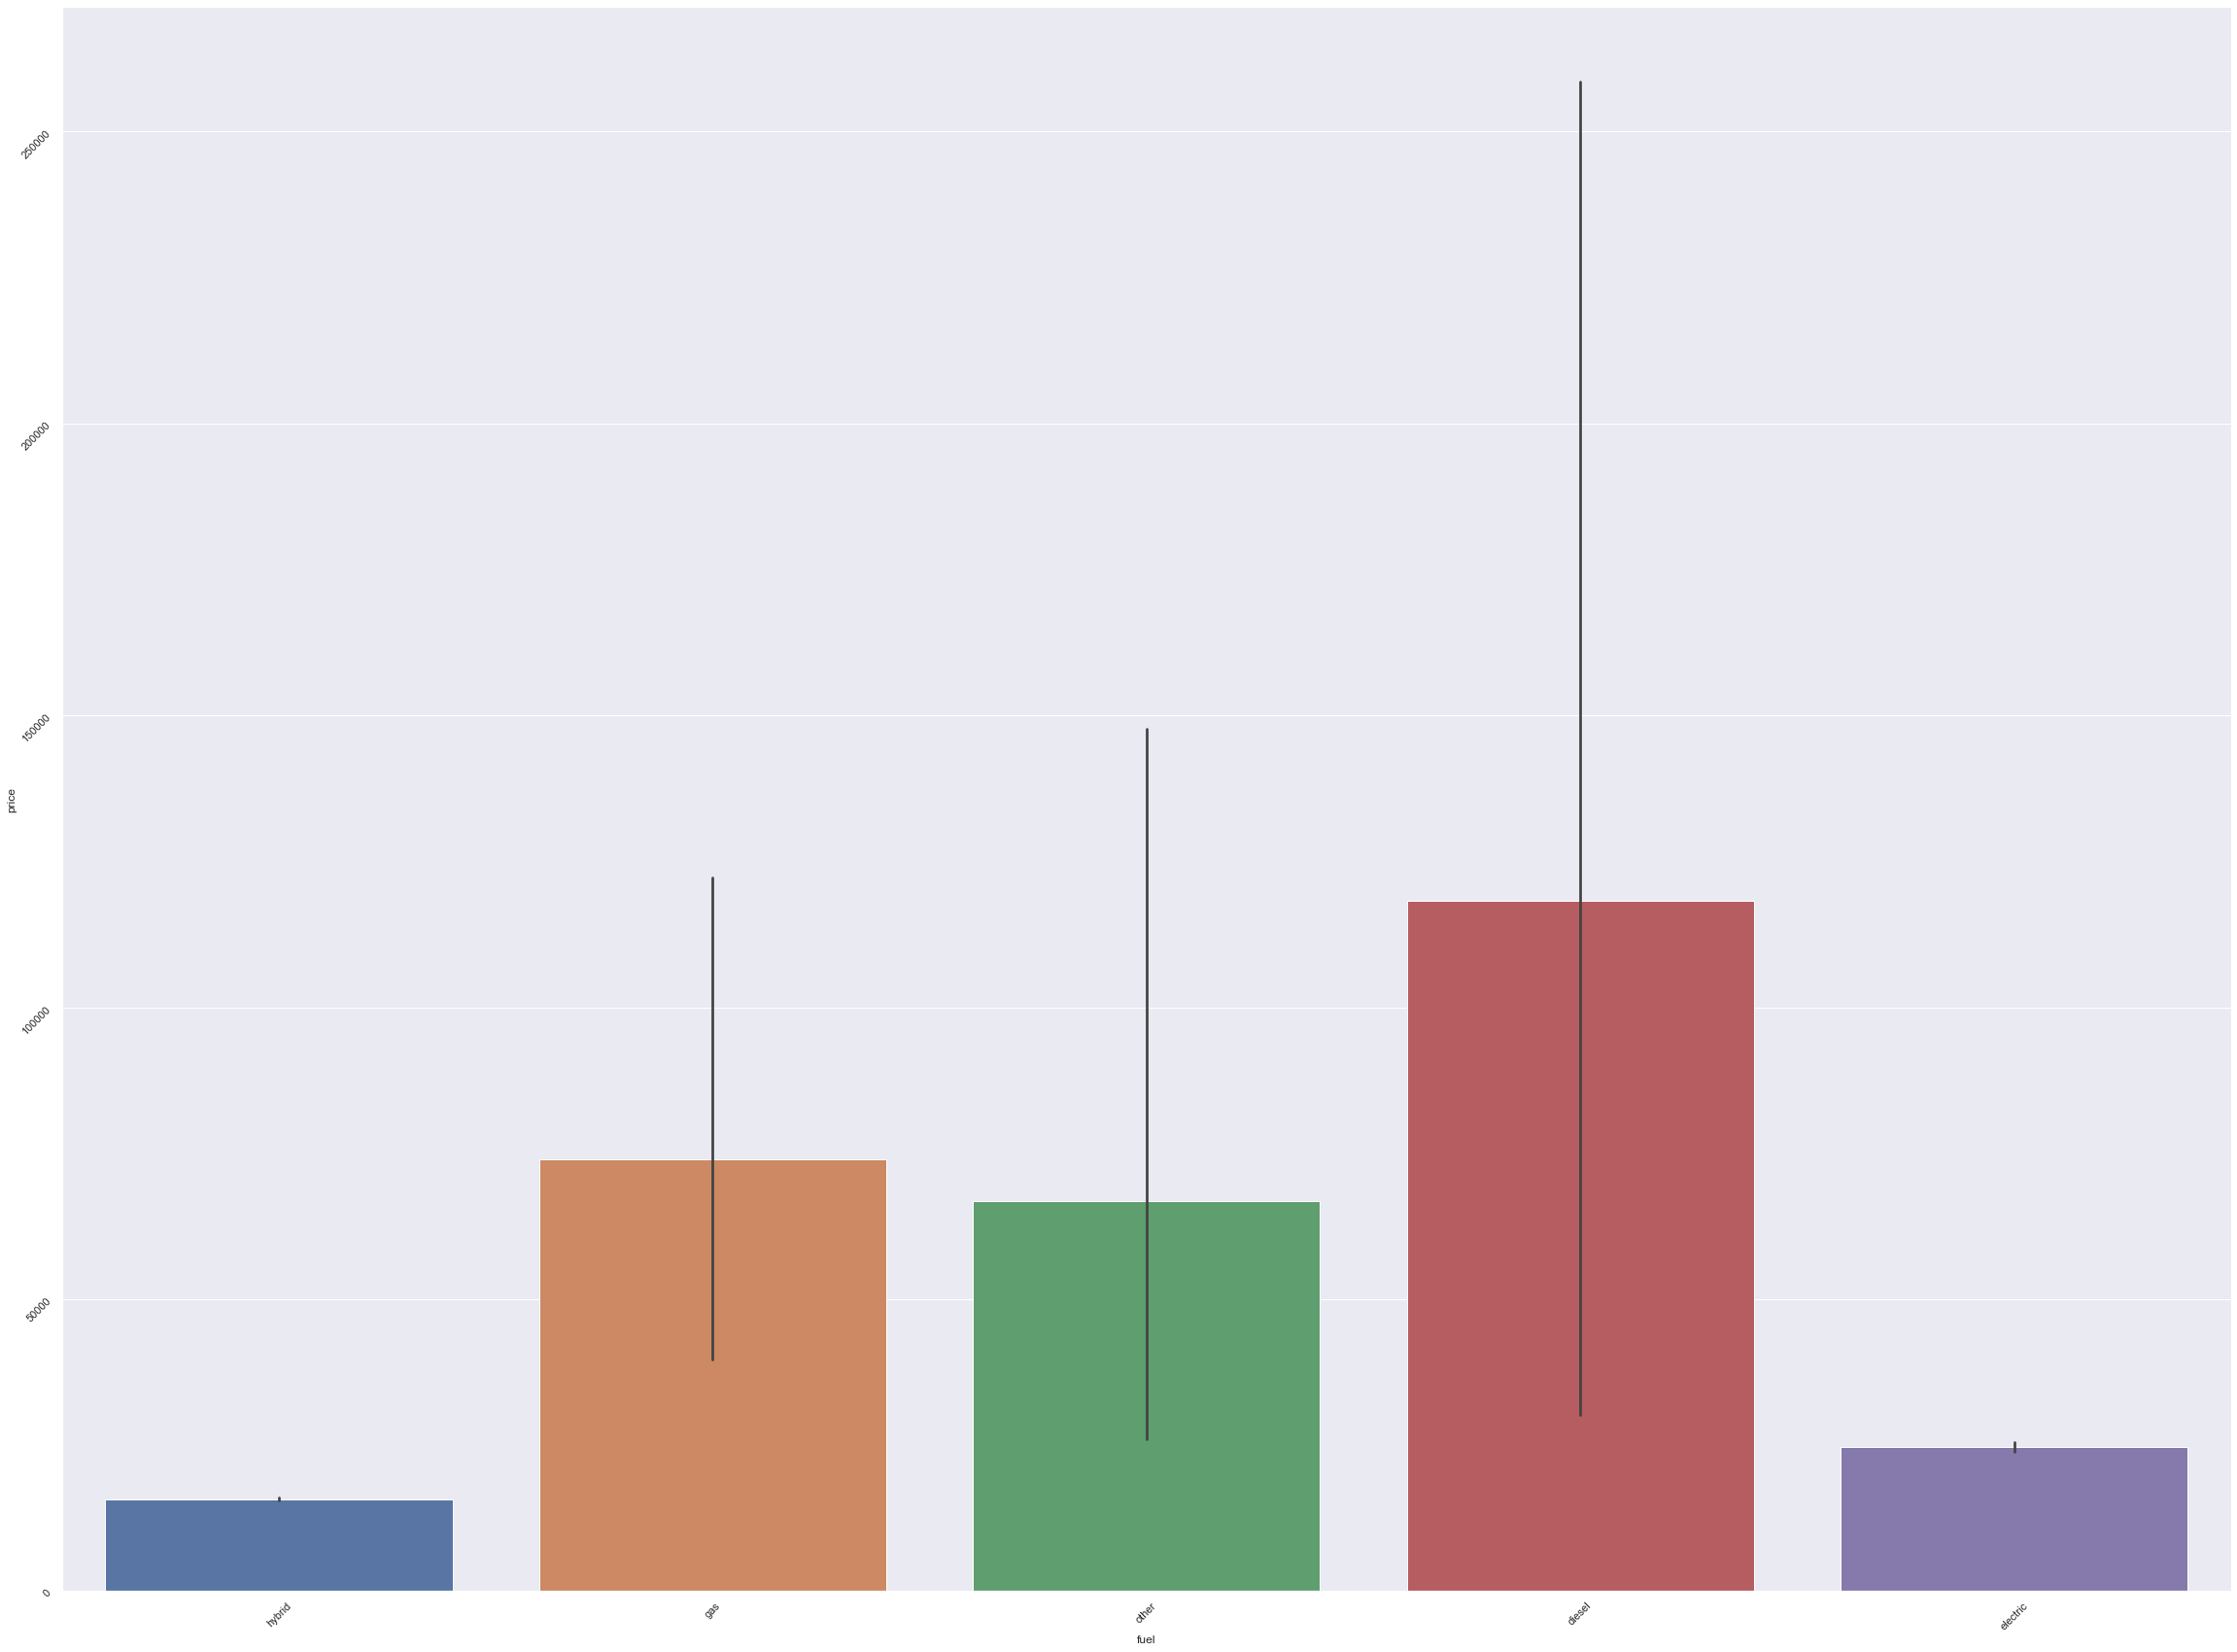

In [45]:
#'manufacturer','fuel','odometer','title_status','transmission','drive','type','state','price'
sns.barplot(data=df,x='fuel',y='price')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

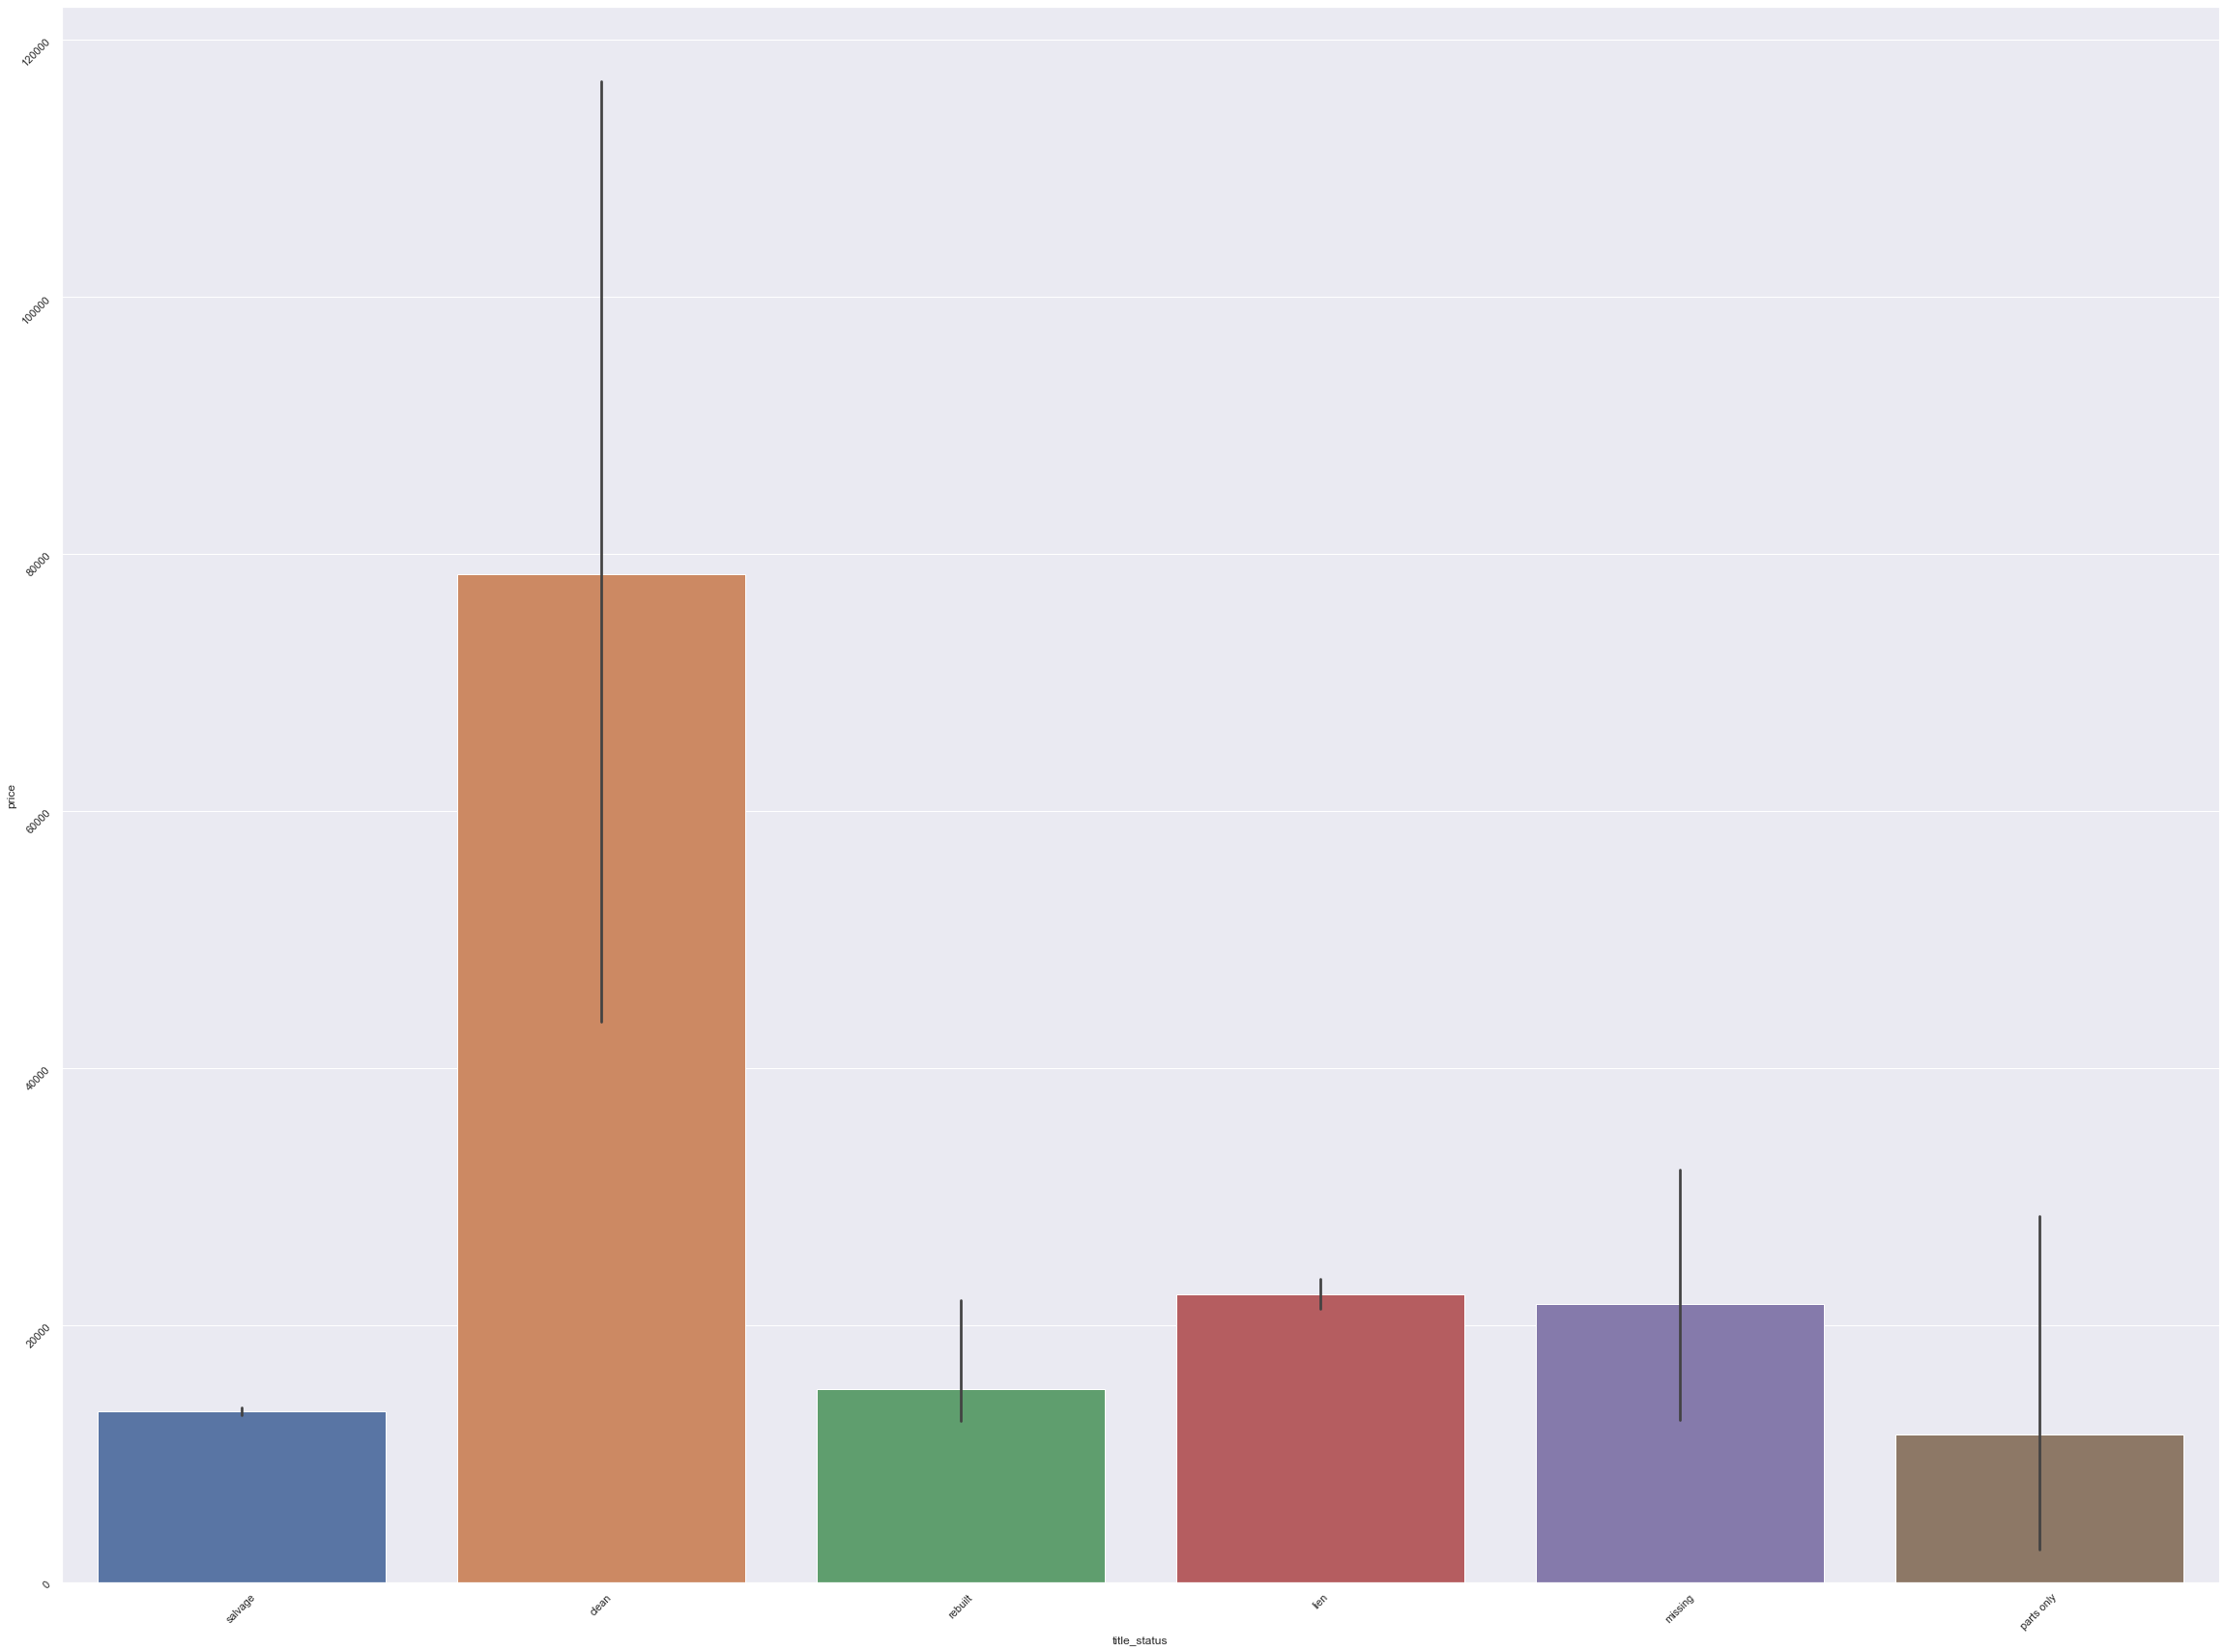

In [191]:
#'manufacturer','fuel','odometer','title_status','transmission','drive','type','state','price'
sns.barplot(data=df,x='title_status',y='price')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

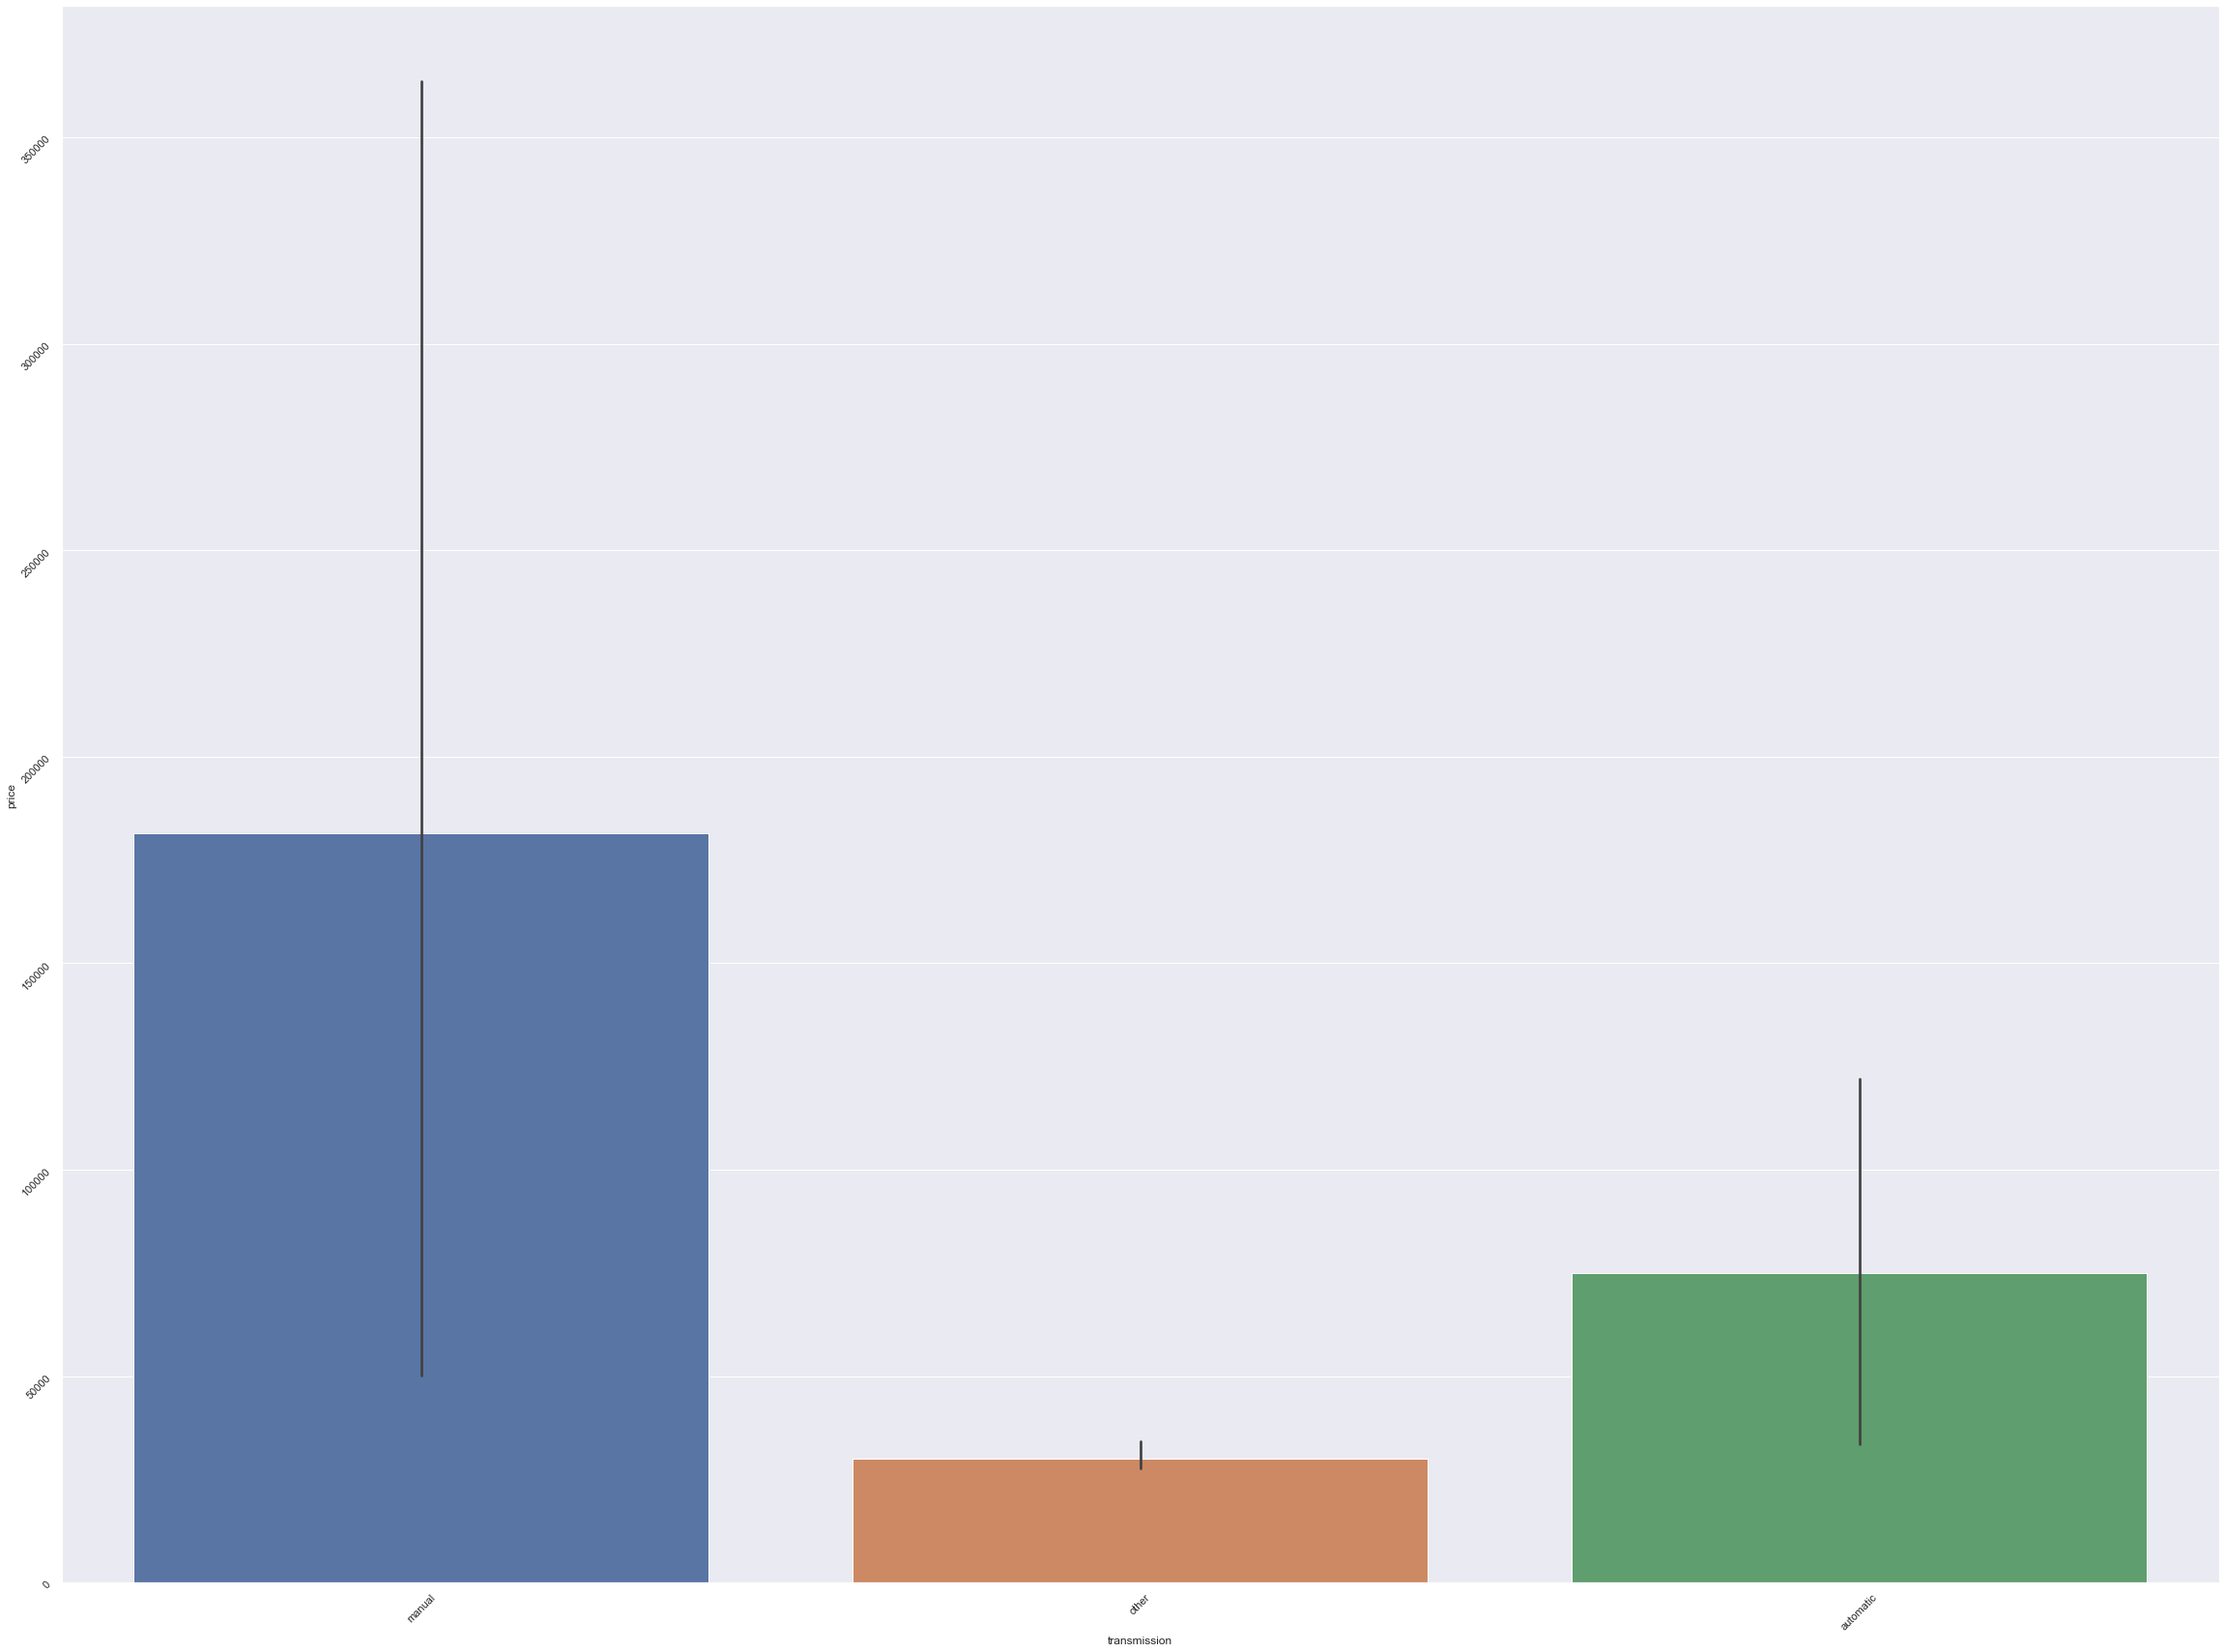

In [192]:
#'manufacturer','fuel','odometer','title_status','transmission','drive','type','state','price'
sns.barplot(data=df,x='transmission',y='price')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

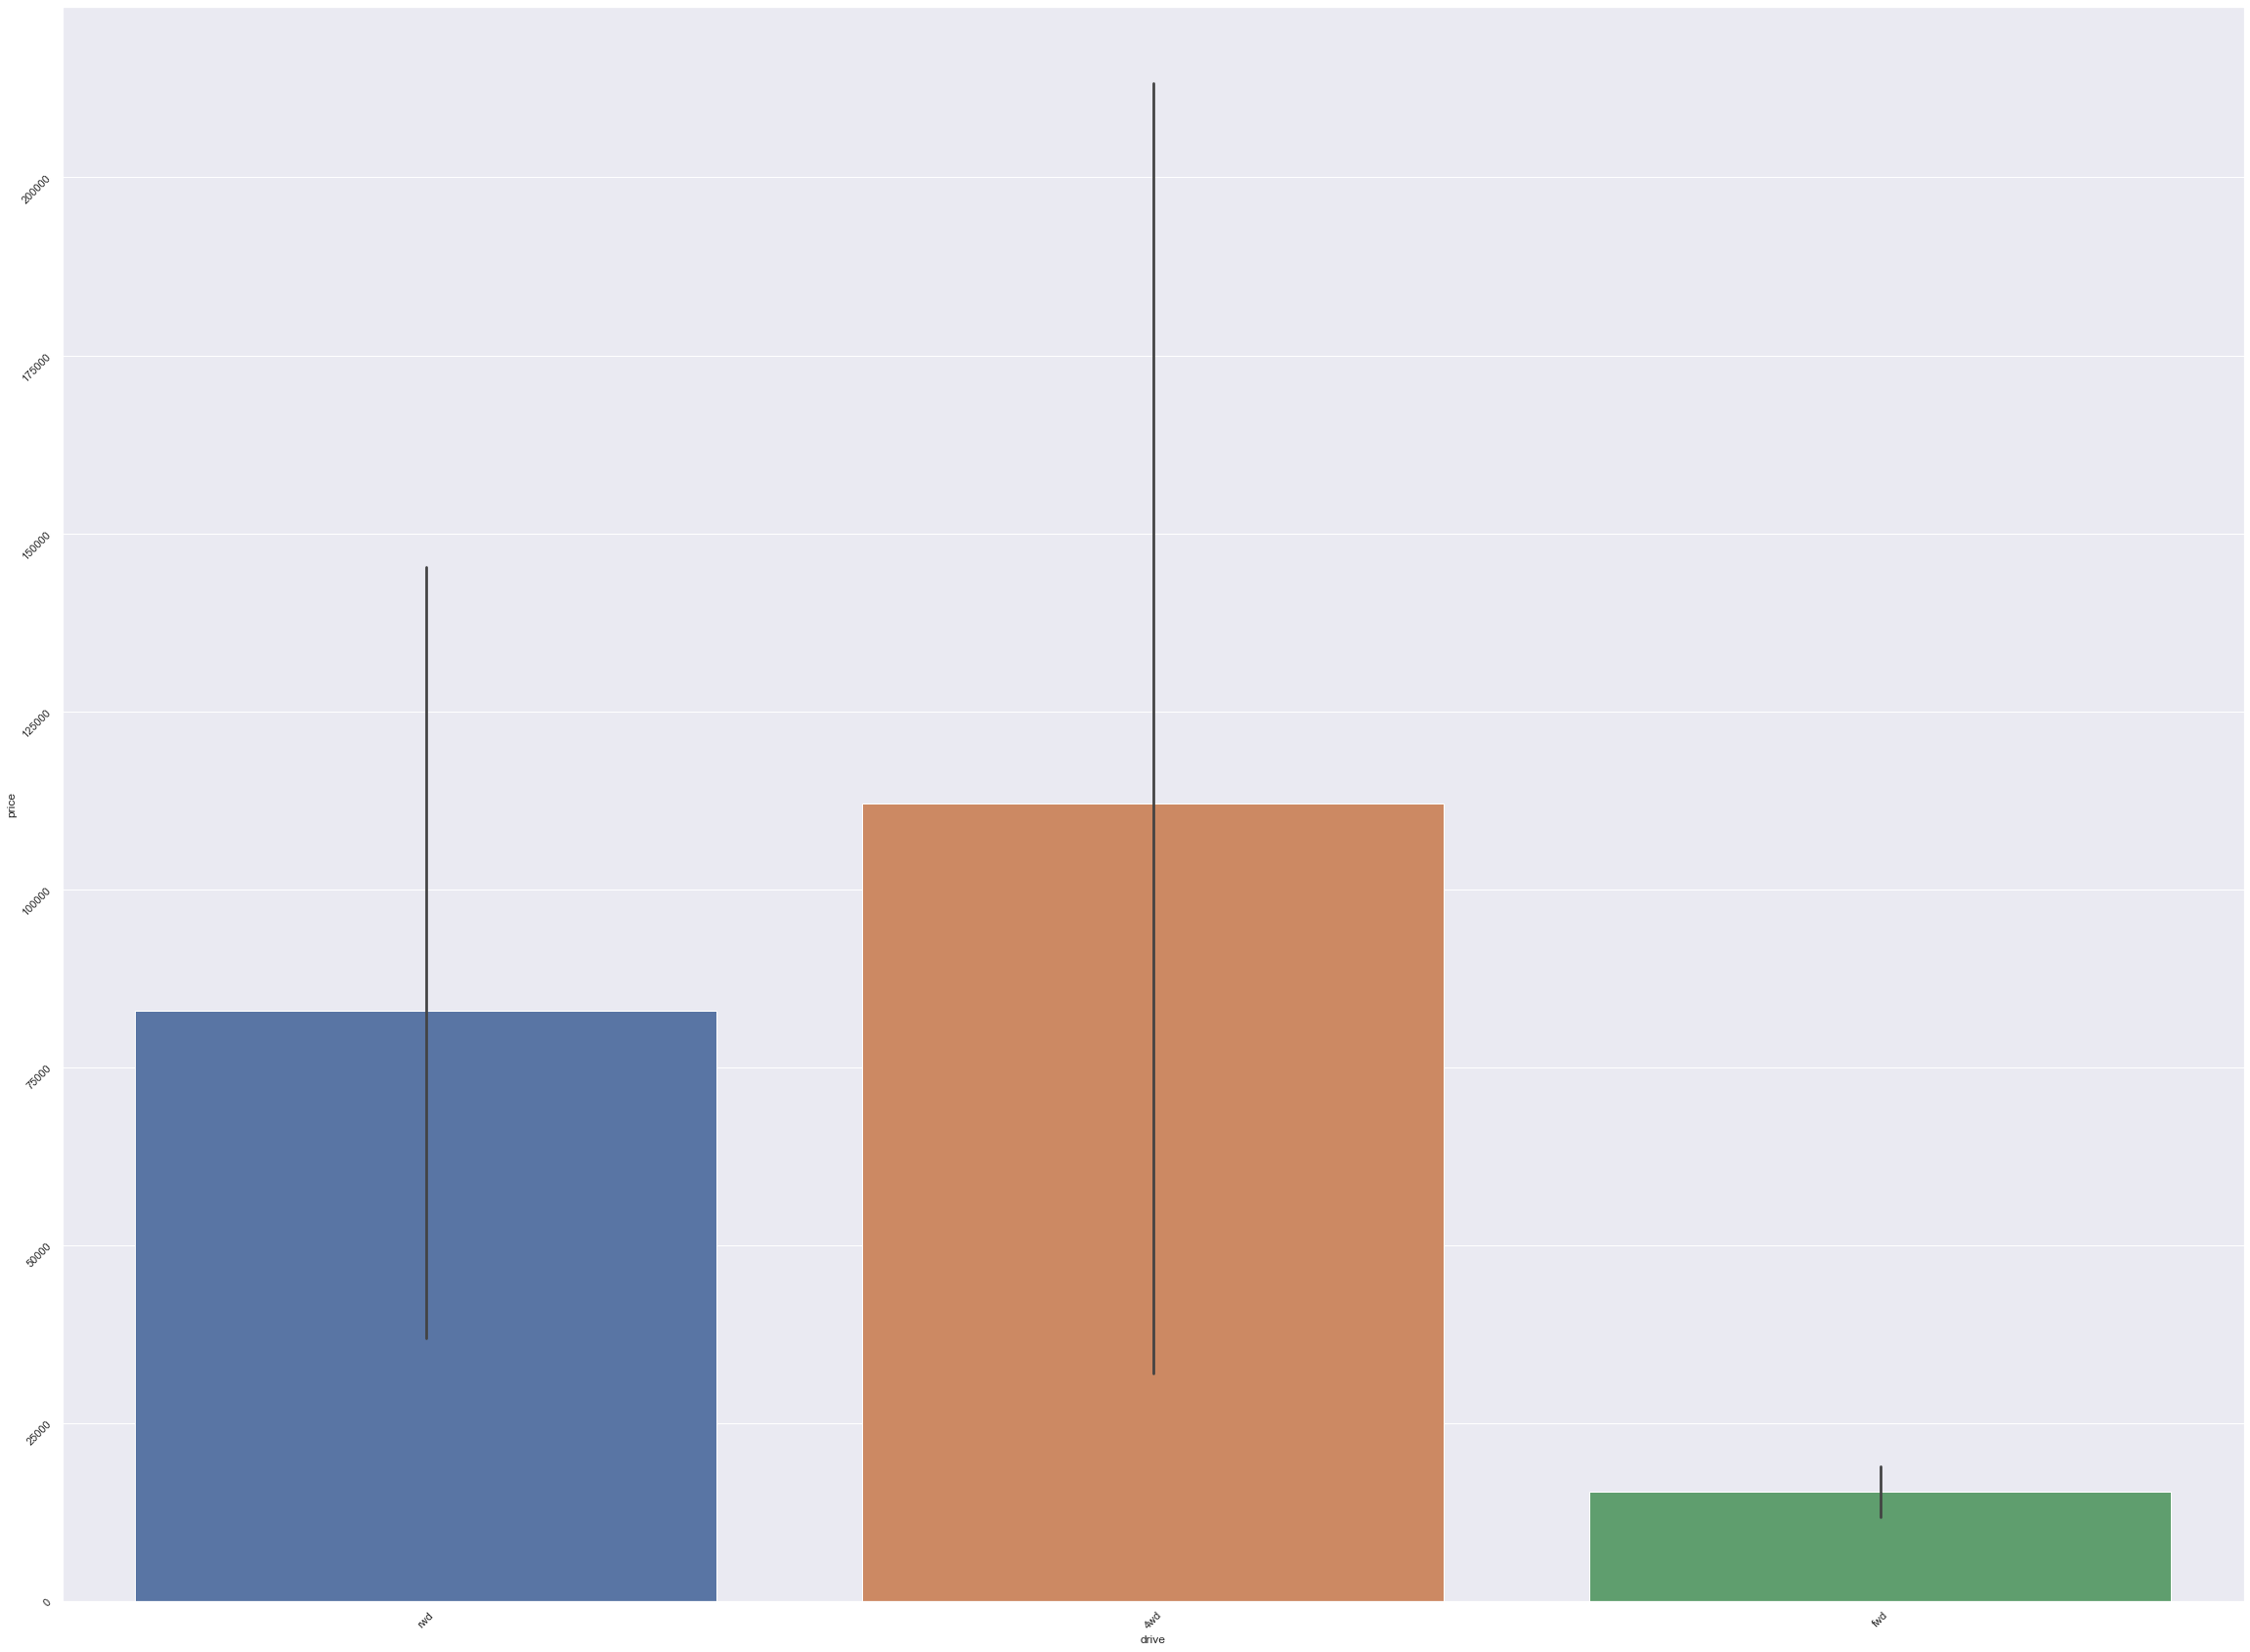

In [193]:
#'manufacturer','fuel','odometer','title_status','transmission','drive','type','state','price'
sns.barplot(data=df,x='drive',y='price')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

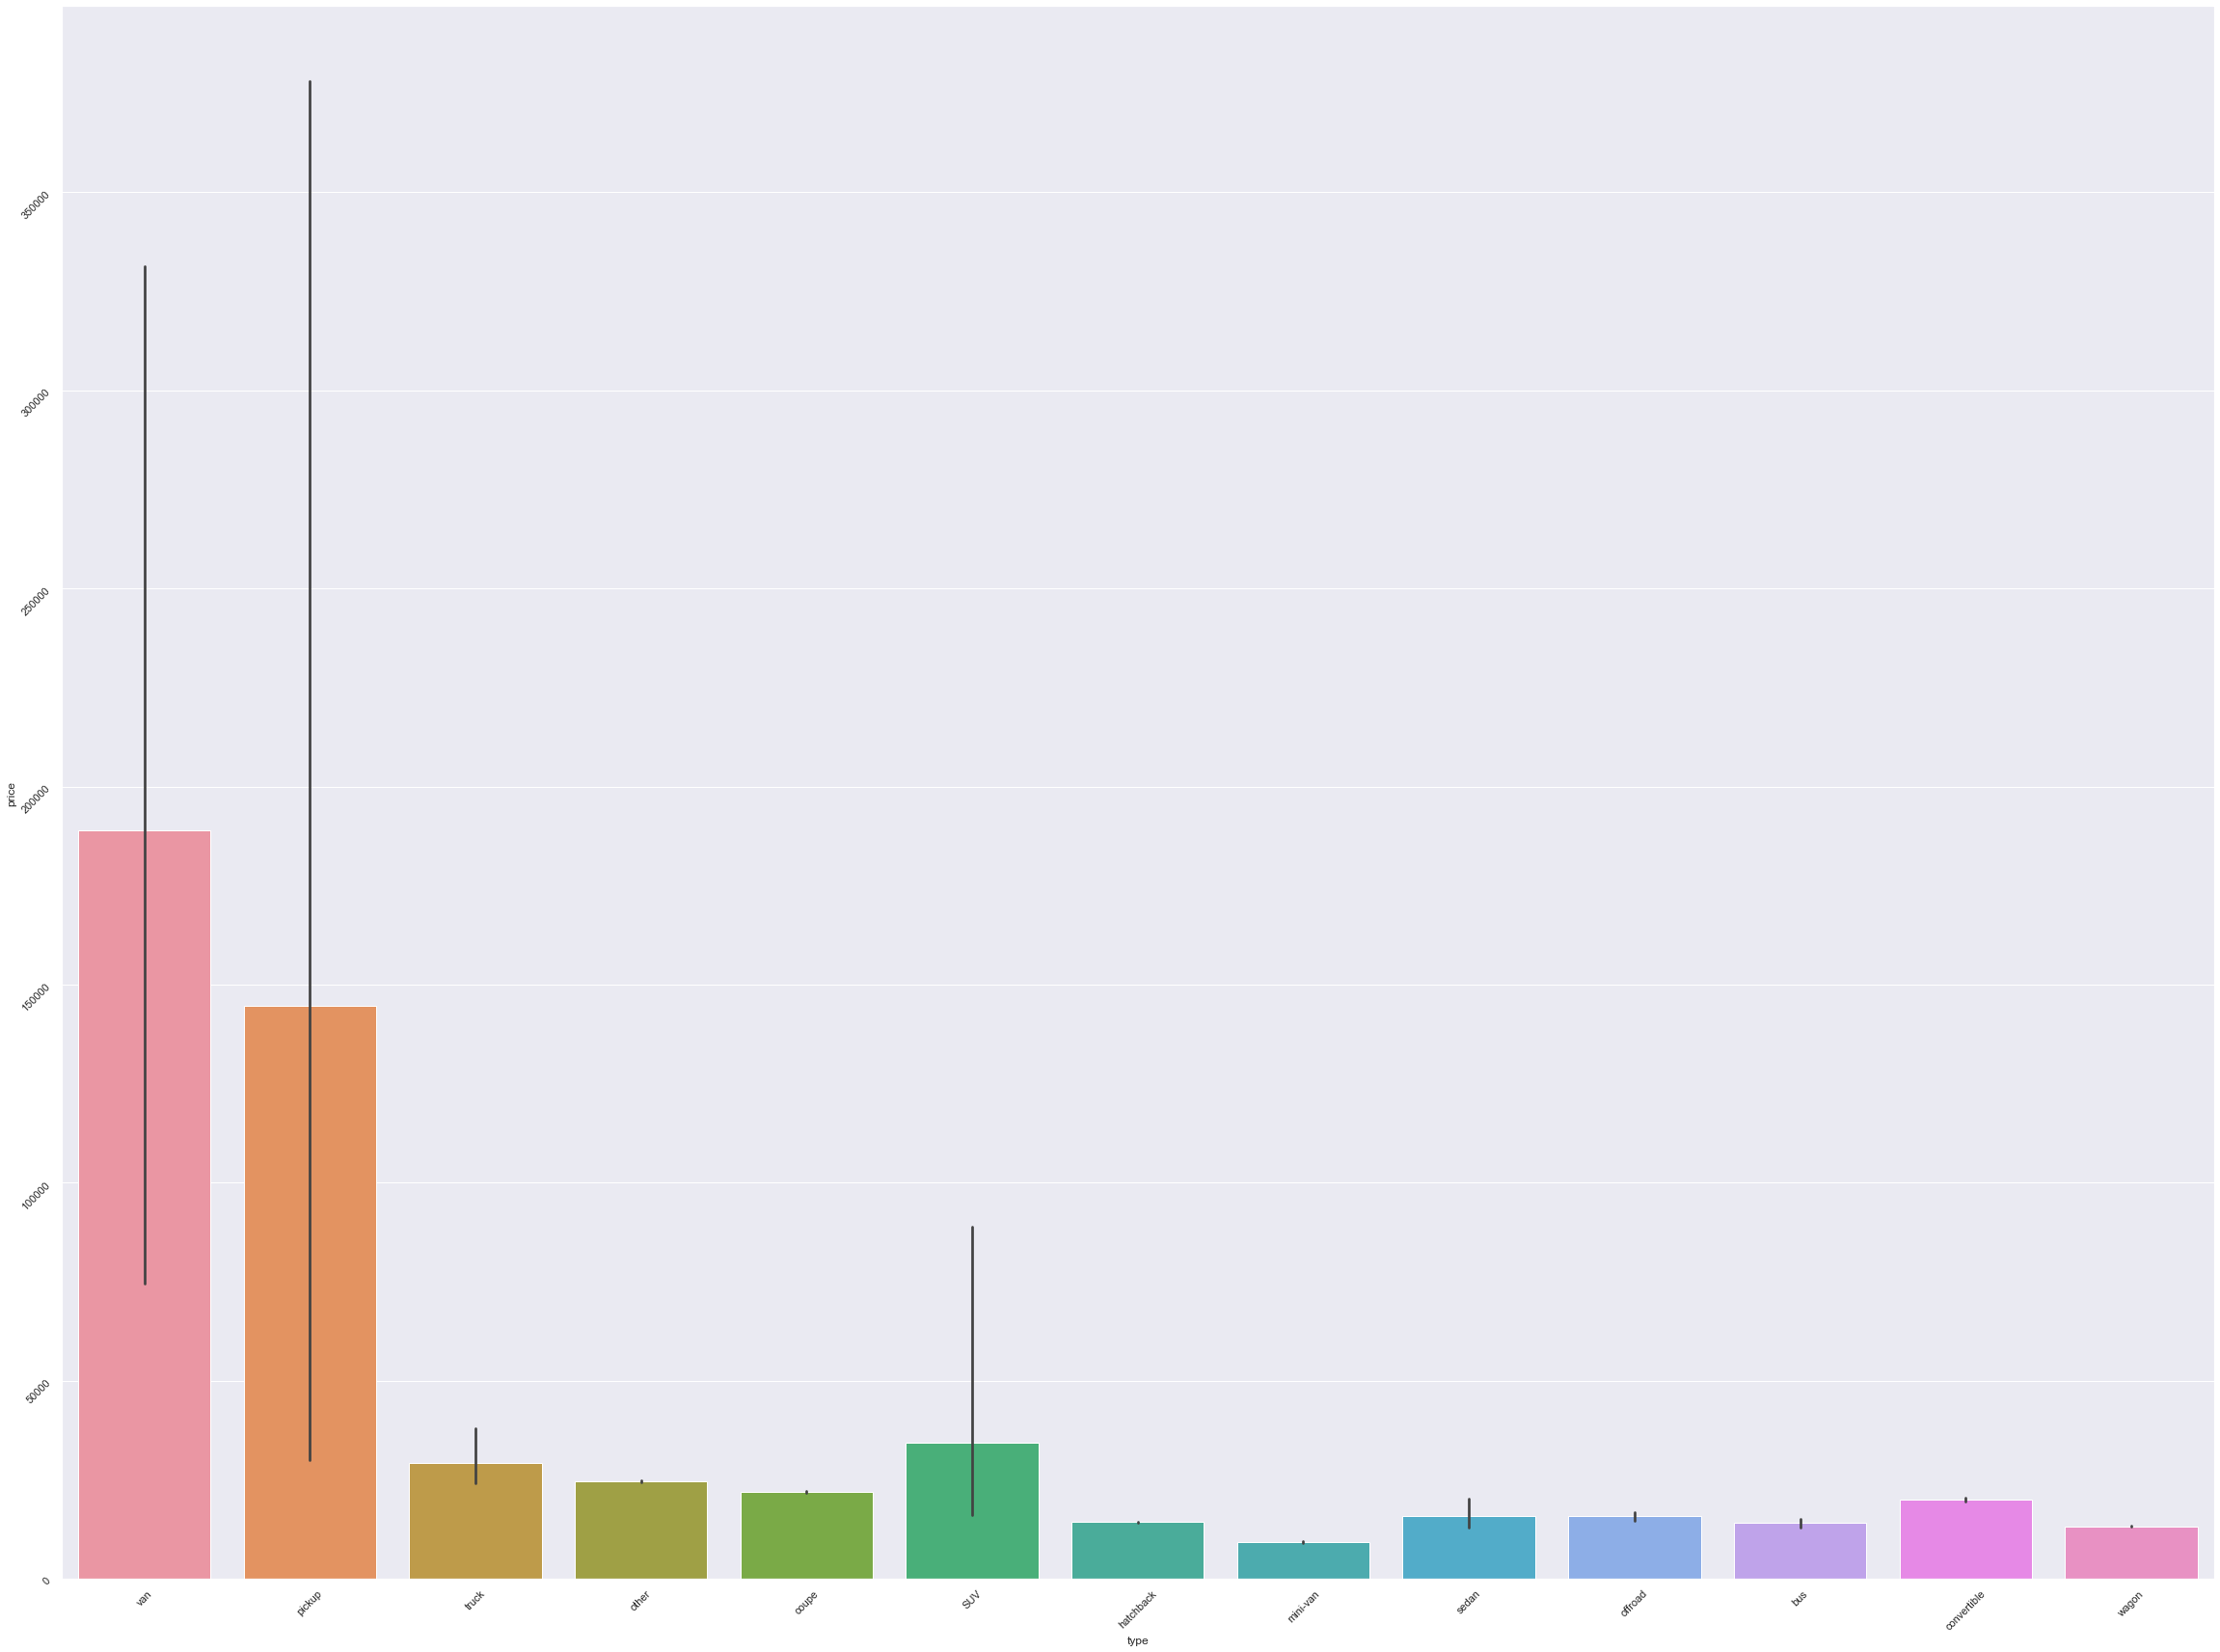

In [194]:
#'manufacturer','fuel','odometer','title_status','transmission','drive','type','state','price'
sns.barplot(data=df,x='type',y='price')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

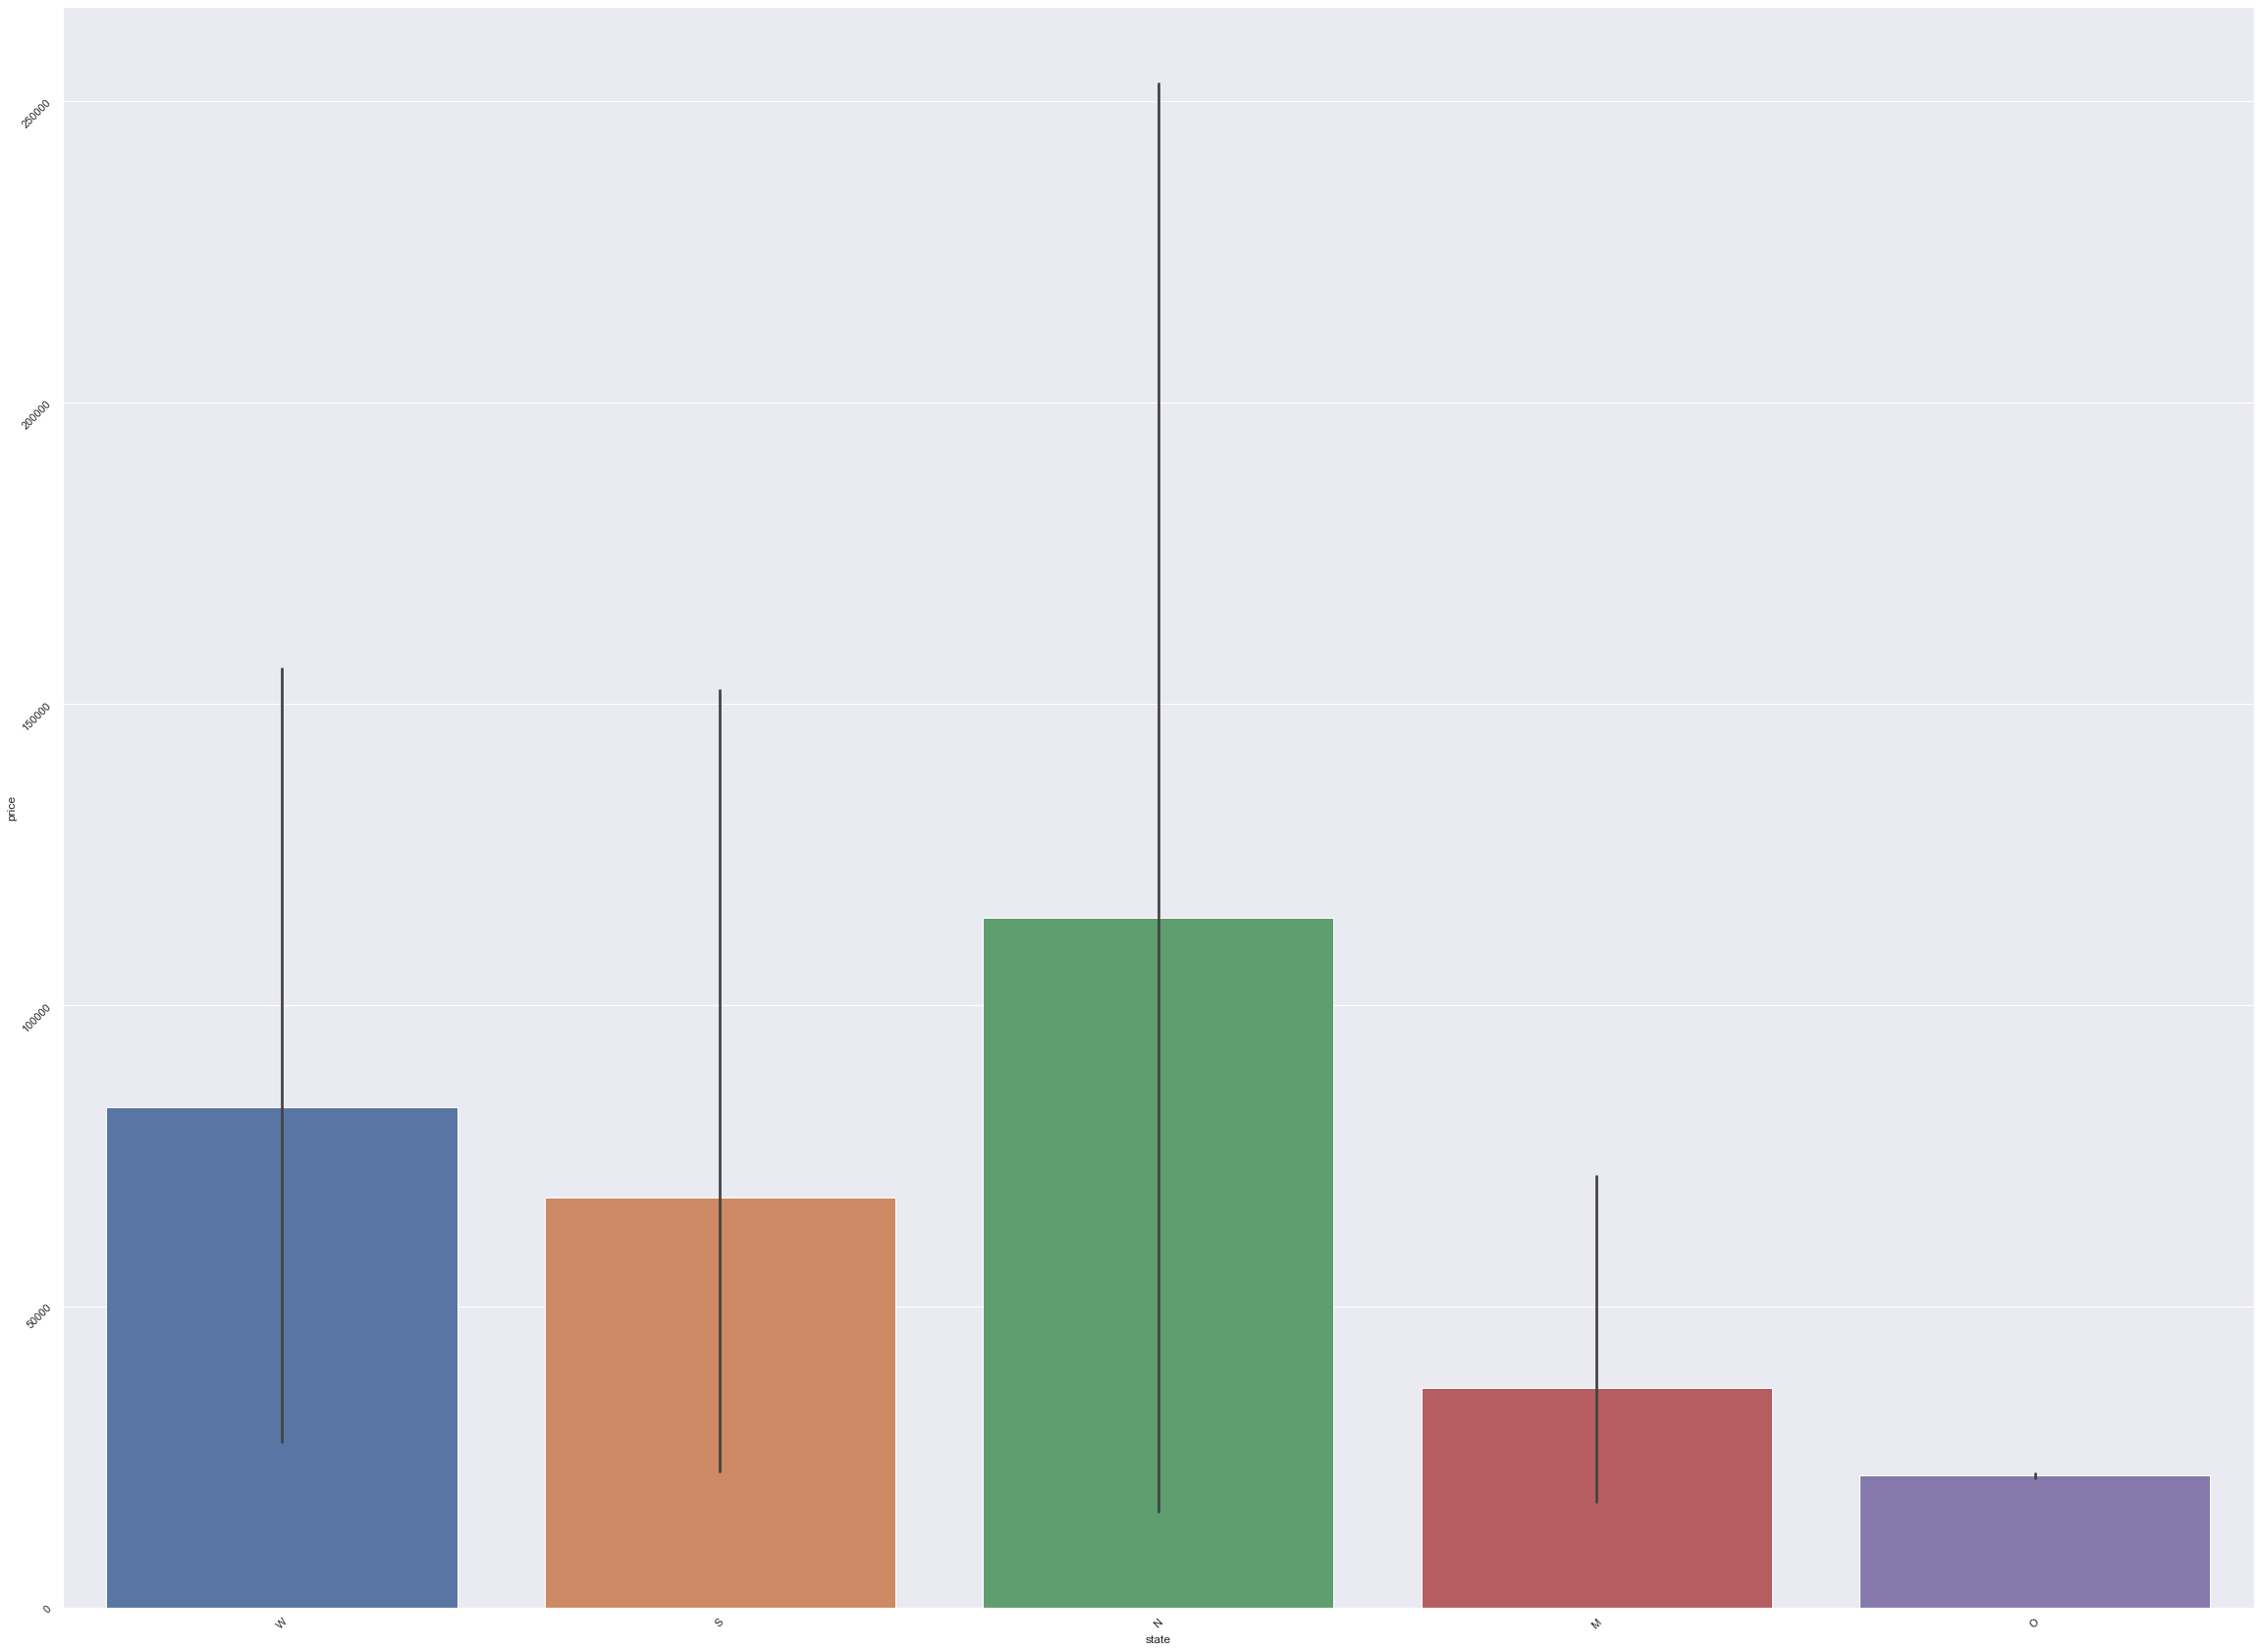

In [195]:
#'manufacturer','fuel','odometer','title_status','transmission','drive','type','state','price'
sns.barplot(data=df,x='state',y='price')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

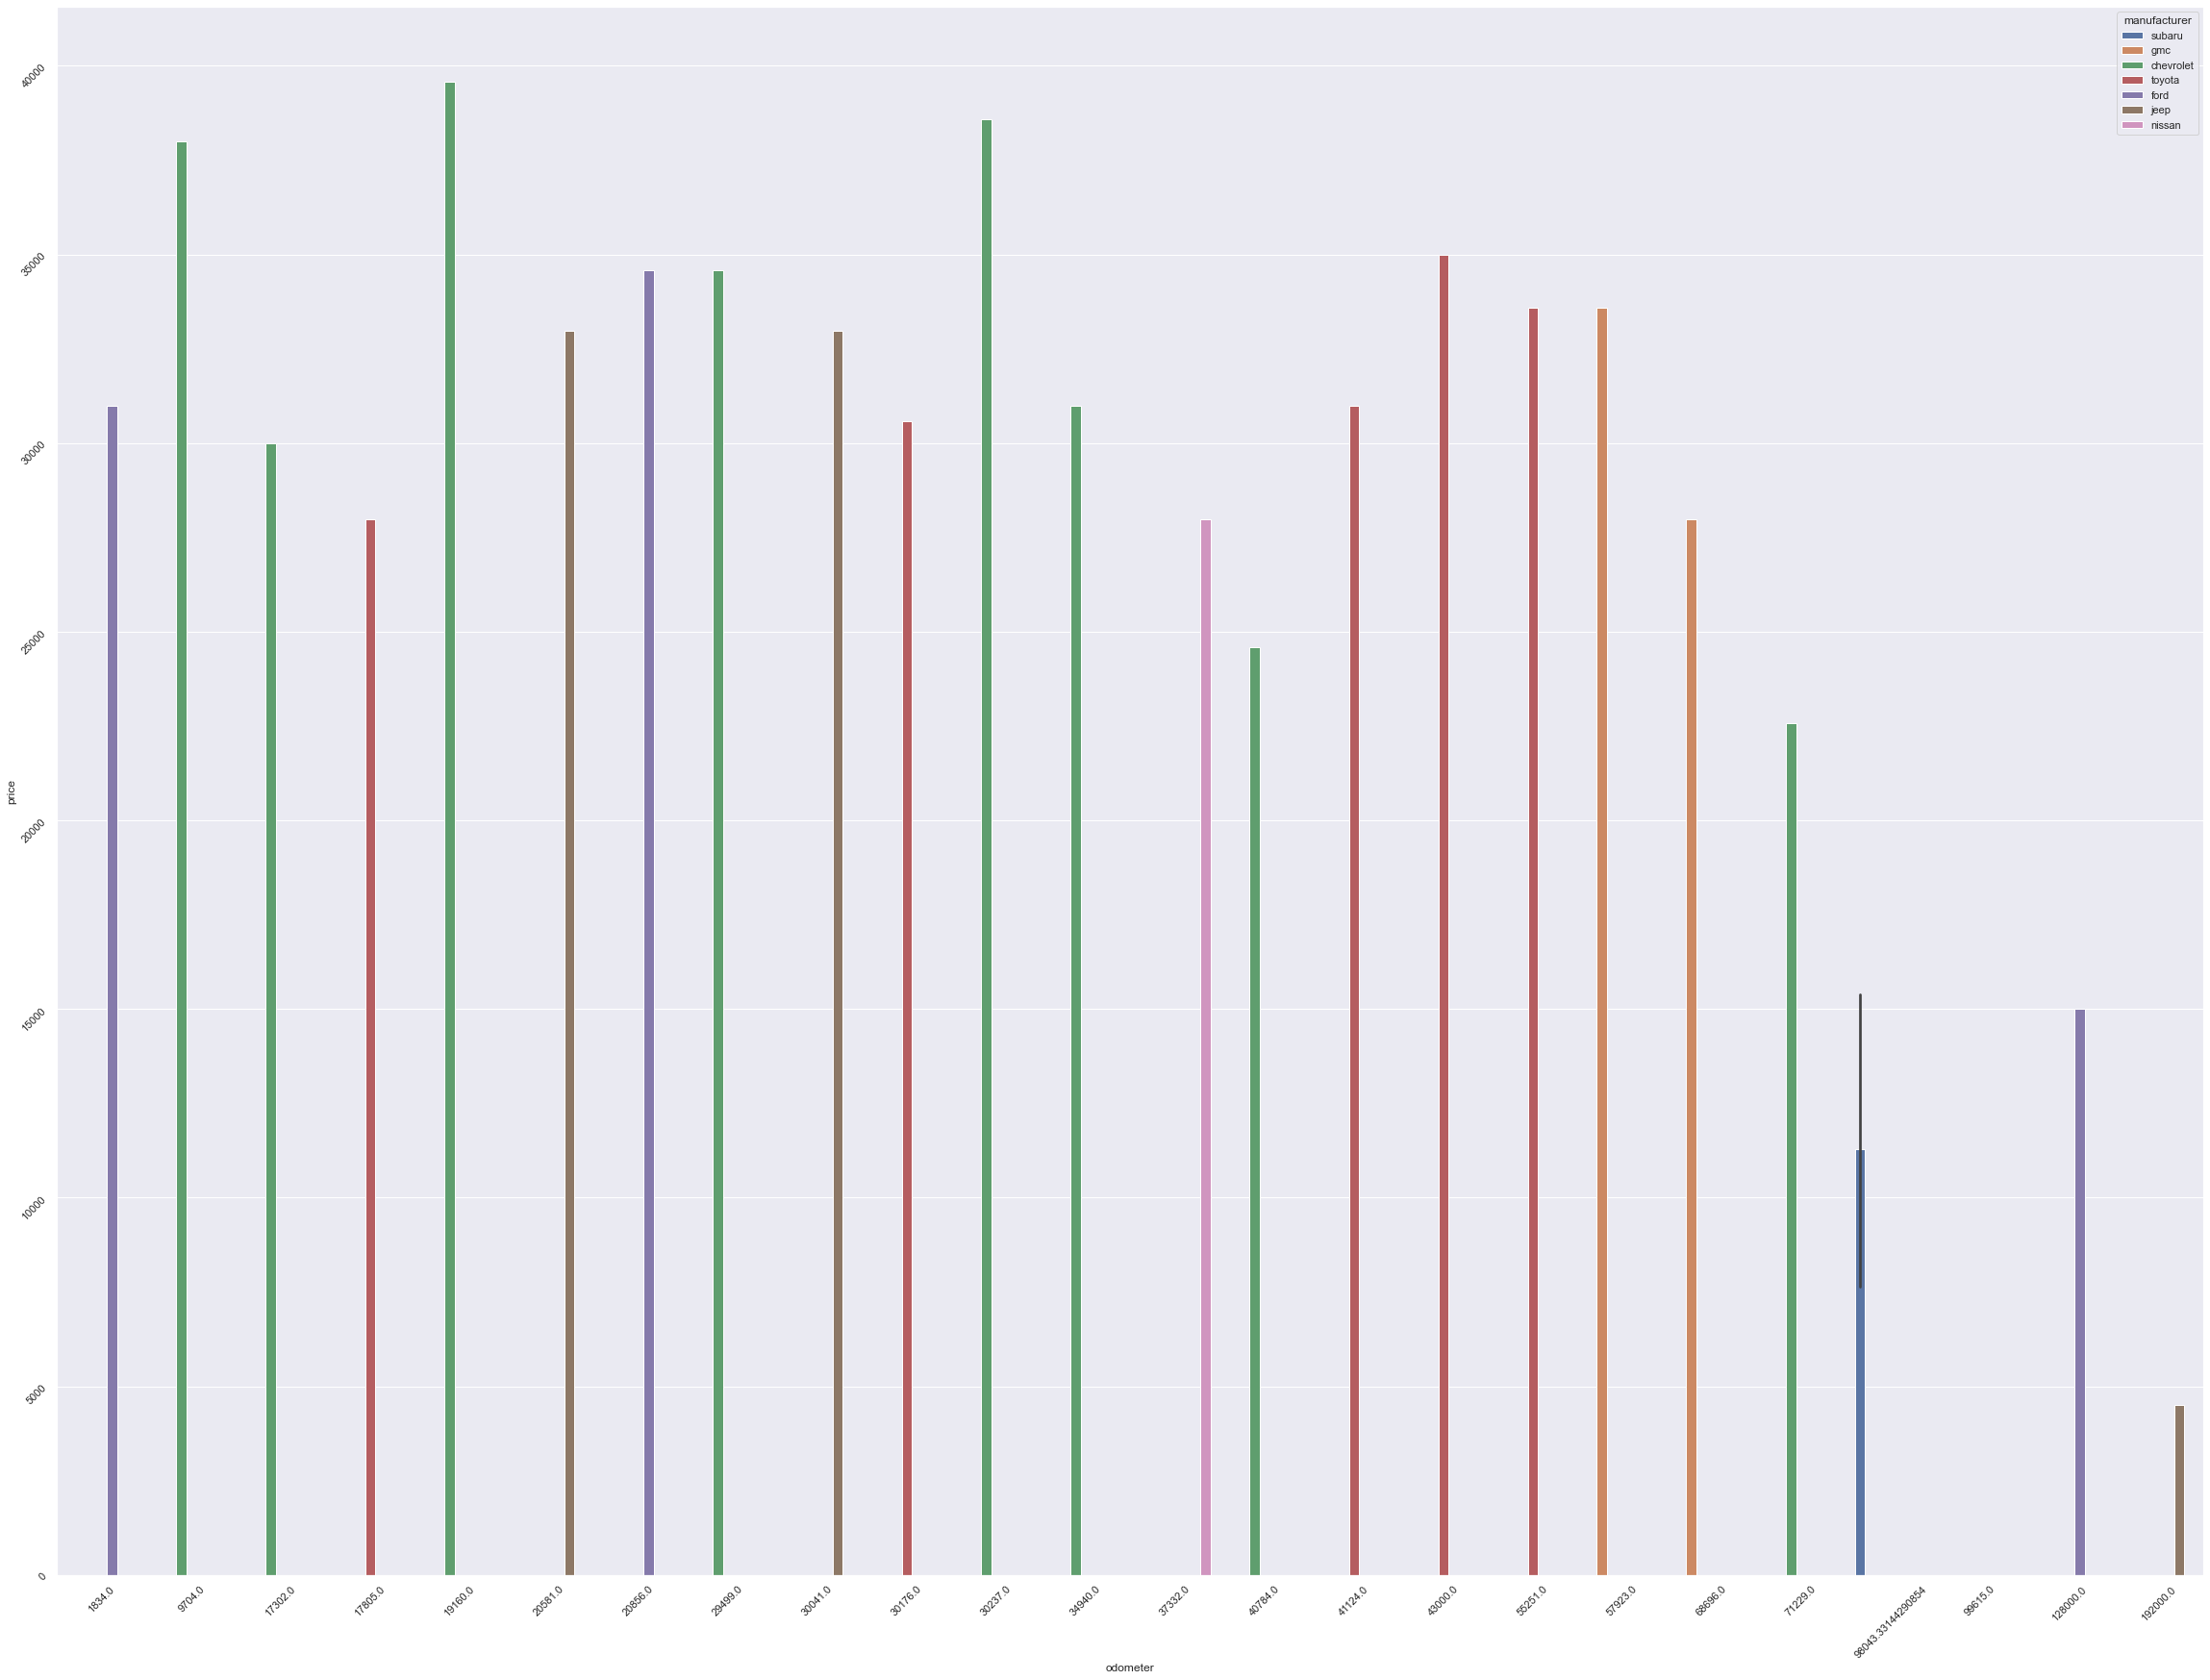

In [61]:
#'manufacturer','fuel','odometer','title_status','transmission','drive','type','state','price'
sns.barplot(data=df.head(50),x='odometer',y='price',hue='manufacturer')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

### Key Drivers to the cost of used Car are as follows :-
##### 1. Manufacturer - Mercedes Benz is the most valuable driver in the used car segment
##### 2. Fuel - Diesel variation is most popular in the used car segment
##### 3. Odometer - The most important feature driving the price of used car segment. 
##### 4. Title Status - Clean title is the most important in driving the car price.
##### 5. Transmission - Contrary to the general knowledge Manual transmission appears to be more popular choice.
##### 6. Drive - 4 WD is the most popular in the used car segment
##### 7. Type - Van is the most preferred type in the used car Segment
##### 8. State - Demand for used car is highest in the Northern states of United States of America